# Dissecting Spotify Valence

In this assignment we will dissect Spotify's Valence metric.

---

> Chalkiopoulos Georgios, Electrical and Computer Engineer NTUA <br />
> Data Science postgraduate Student <br />
> gchalkiopoulos@aueb.gr

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Our task is to untangle the mystery behind valence and propose how this is derived.

Spotify offers the following information, relevant to our task:

* [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

* [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).


# Results
The best achived result is a MAE of 0.087 using an Extra Trees Regressor.

# Getting the data

In [123]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime
import time
import os
import itertools
from itertools import combinations
import warnings

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")

%matplotlib inline

## Download the top-streaming songs of the 2017-2019 period

We would like to explore the top-streaming apps in Spotify around the world which are provided by Spotify Charts.

Unfortunately, although the data are downloadble in CVS format, we cannot scrape them as access to them is guarded by CloudFare. Fortunately, data for some countries and the world as a whole, for the period 2017-2019, is available in Zenodo https://doi.org/10.5281/zenodo.4778562 :

  * Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.
We'll download the charts data (charts.zip).

After downloading it places data for each region in per-year directories. In each one of these, charts are given in weekly files, so we'll read all for them and record the week and region.

In [124]:
header = 0
dfs = []
for file in glob.glob('../Charts/*/201?/*.csv'):
    region = file.split('/')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...


* There are tens of thousands of songs in the charts, but not all of them are unique:

In [125]:
len(all_charts['song_id'].unique())

13880

### Setting up the Spotify API*

\* The section in this part uses code from the Course "Practical Data Science" performed in the MSc Data Science program at AUEB by prof. Panos Louridas

* For storing our credentials, we'll create a file spotify_config.py with the following contents:

In [126]:
config = {
    'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
}

* Then we can create a Spotify client.

In [127]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

* Download the tracks in batches of 100 (limit for free user) and add them a a dict named features.

In [128]:
def get_features(list_of_ids):
    """
    Function to get features of a song, using the spotify API
    INPUT: list of unique song ids
    OUTPUT: feature dictionary for the songs
    """
    features_func = {}
    all_track_ids = list_of_ids 

    start = 0
    num_tracks = 100
    while start < len(all_track_ids):
        print(f'getting from {start} to {start+num_tracks}')
        tracks_batch = all_track_ids[start:start+num_tracks]
        features_batch = sp.audio_features(tracks_batch)
        features_func.update({ track_id : track_features 
                        for track_id, track_features in zip(tracks_batch, features_batch) })
        start += num_tracks
    return features_func



In [129]:
features = get_features(list(all_charts['song_id'].unique()))

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

In [130]:
len(features)

13880

* Let's verify that we got all of them and see how one looks.

In [7]:
features['7qiZfU4dY1lWllzX7mPBI3']

{'danceability': 0.825,
 'energy': 0.652,
 'key': 1,
 'loudness': -3.183,
 'mode': 0,
 'speechiness': 0.0802,
 'acousticness': 0.581,
 'instrumentalness': 0,
 'liveness': 0.0931,
 'valence': 0.931,
 'tempo': 95.977,
 'type': 'audio_features',
 'id': '7qiZfU4dY1lWllzX7mPBI3',
 'uri': 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'track_href': 'https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3',
 'duration_ms': 233713,
 'time_signature': 4}

* Spotify also offers the [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) API, sonsisting of the following parts:

In [128]:
sp.audio_analysis('5aAx2yezTd8zXrkmtKl66Z').keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'sections', 'segments', 'tatums'])

In order to see if there is any usefull info, we looked through the response example and concluded that the `track` part of the response might have some usefull info. 
* Before fetching any data from that, let's see what parts of the track are not available in the `audio_features` API

In [12]:
for key in sp.audio_analysis('5aAx2yezTd8zXrkmtKl66Z')['track']:
    if key not in features['5aAx2yezTd8zXrkmtKl66Z'].keys():
        print(key)

num_samples
duration
sample_md5
offset_seconds
window_seconds
analysis_sample_rate
analysis_channels
end_of_fade_in
start_of_fade_out
codestring
code_version
echoprintstring
echoprint_version
synchstring
synch_version
rhythmstring
rhythm_version


* Based on the columns available we will download the confidence parts of the `audio_features`. Moreover, we will download the min and max loudness as well as the average mode from the `sections` part, (since a single value is given in the `track` part.) and keep more info as shown below: 

In [131]:
def update_with_extra_features(features):
    # create column names for pitch and timbre
    pitch_names = [f'pitch_{n}' for n in range(0,12)]
    timbre_names = [f'timbre_{n}' for n in range(0,12)]


    print('Start fetching extra features')
    for i, id in enumerate(features):
        if i % 100 == 0:
            print(f'fetching {i} of {len(features)}')

        # skips songs that have already been processed
        if 'max_loundness' in features[id].keys():
            continue
        else:
            try:
                analysis = sp.audio_analysis(id)
                features[id].update({feat : val for feat, val in analysis['track'].items()
                        if bool(re.match('tempo_confidence|time_signature_confidence|key_confidence|mode_confidence', feat))})

                # initiate values
                max_loundness = -99
                min_loundness = 20
                mode_seg_0 = 0
                count_mode = 0
                fade_in = analysis['track']['end_of_fade_in']
                fade_out = analysis['track']['start_of_fade_out']

                # calculate mode, loudness max/min for each section
                for sec in analysis['sections']:
                    count_mode += 1
                    if sec['mode'] == 0:
                            mode_seg_0 += 1
                    if sec['start'] > fade_in and sec['start'] < fade_out:
                        if sec['loudness'] > max_loundness:
                            max_loundness = sec['loudness']
                        if sec['loudness'] < min_loundness:
                            min_loundness = sec['loudness']
                    

                # calculate average pitch and timbre based on segments part
                pitch_values = np.array([seg['pitches'] for seg in analysis['segments']]).mean(axis=0)
                timbre_values = np.array([seg['timbre'] for seg in analysis['segments']]).mean(axis=0)

                # create dict for pitch and tibmre
                pitch = {p : v for p, v in list(zip(pitch_names, pitch_values))}
                timbre = {t : tv for t, tv in list(zip(timbre_names, timbre_values))}

                if count_mode == 0:
                    mode_seg = 0
                else:
                    mode_seg = mode_seg_0/count_mode 
                extra_features = {
                'max_loundness' : max_loundness ,
                'min_loundness' : min_loundness ,
                'mode_seg_0' : mode_seg ,
                'fade_in' : fade_in,
                'fade_out' : fade_out,
                **pitch, **timbre
                }


                features[id].update(extra_features)
            
            except:
                print("Waiting for 1 sec")
                time.sleep(1)

* This part downloads the exrta features under the `segment` and `section` part of the audio analysis, and will take a lot of time to be excecuted.

In [ ]:
update_with_extra_features(features)

* We'll turn the dictionary to a DataFrame.

In [170]:
# create df, reset index (since the song id is currently index) and rename to song_id
try:
    df = pd.DataFrame.from_dict(features, orient='index').reset_index().rename(columns={'index': 'song_id'})
    df.head()
    print('DataFrame created!')
except:
    df = pd.read_csv('./audio_features_extra.csv')
    print('DataFrame loeaded from file.')

DataFrame loeaded from file.


* save to csv to have it available next time

In [112]:
# df.to_csv('./audio_features.csv')
if os.path.exists('./audio_features_extra.csv'):
    print('File already exists, not saving.')
    pass
else:
    df.to_csv('./audio_features_extra.csv', index=False)
    print('Dataframe saved under audio_features_extra.csv')

Dataframe saved under audio_features.csv


# Download extra songs

For this section please refer to [Appendix 2](#Appendix_2). Two extra files were downloaded using Data Crawling and the Spotify [`Search for Item`](https://developer.spotify.com/documentation/web-api/reference/#/operations/search) API.
When completed you should have the following files:

* audio_features_spotify_scrap.csv
* audio_features_spotify_search.csv

These files are going to be used in [Section 2](#2ection_2), thus we are not loading them yet.

## Test Dataset

* The evaludation will be done based on a test dataset, of which only the ids are available. 

We will follow the previous steps to download the same information and save the dataframe into a csv file.

* After reading the song ids from the file, we will perform the same steps as before. That is get the initial features and then update the dictionary with the extra features

In [132]:
# add the ids into a list
test_id = []
with open('./spotify_ids.txt', 'r') as f:
    for line in f.readlines():
        test_id.append(line.strip())

# get initial features  
features_test = get_features(test_id)    


getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200


* This part downloads the exrta features under the `segment` and `section` part of the audio analysis, and will take a lot of time to be excecuted.

In [133]:
update_with_extra_features(features_test)

Start fetching extra features
fetching 0 of 1162
fetching 100 of 1162
fetching 200 of 1162
fetching 300 of 1162
fetching 400 of 1162
fetching 500 of 1162
fetching 600 of 1162
fetching 700 of 1162


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ with Params: {} returned 404 due to analysis not found


fetching 800 of 1162
Waiting for 1 sec
fetching 900 of 1162
fetching 1000 of 1162
fetching 1100 of 1162


* it seems that one song doesn't have analysis for it, thus we will remove it.

In [124]:
features_test.pop('4LaGu95Ui2s4vprSQYWUAZ')

{'danceability': 0.716,
 'energy': 0.67,
 'key': 0,
 'loudness': -6.995,
 'mode': 0,
 'speechiness': 0.101,
 'acousticness': 0.526,
 'instrumentalness': 0,
 'liveness': 0.13,
 'valence': 0.411,
 'tempo': 145.043,
 'type': 'audio_features',
 'id': '4LaGu95Ui2s4vprSQYWUAZ',
 'uri': 'spotify:track:4LaGu95Ui2s4vprSQYWUAZ',
 'track_href': 'https://api.spotify.com/v1/tracks/4LaGu95Ui2s4vprSQYWUAZ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ',
 'duration_ms': 203586,
 'time_signature': 4}

In [217]:
test_df = pd.DataFrame.from_dict(features_test, orient='index').reset_index().rename(columns={'index': 'song_id'})
test_df.head()

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11
0,7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,...,13.186668,-9.708527,33.463126,-16.275168,-0.111490,-0.116343,-2.815301,-2.546181,-9.382599,3.806793
1,5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,...,-7.260601,-13.447243,19.275827,-27.172416,3.210723,-6.942141,-7.276782,-3.543406,-9.379946,-2.194406
2,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,...,-10.005773,-14.477796,12.029462,-27.334700,7.383236,-0.745243,8.223896,2.743308,-12.995984,-0.989638
3,4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,...,-4.694368,-5.696588,35.700039,-20.637354,18.525245,8.093477,-0.432036,0.537412,-13.412574,-7.004807
4,5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,...,-36.346186,2.057222,48.877285,-12.869335,-2.818465,-14.925499,1.476694,2.807862,-21.408289,4.122929


In [127]:
# df.to_csv('./audio_features.csv')
if os.path.exists('./test_df.csv'):
    print('File already exists, not saving.')
    pass
else:
    test_df.to_csv('./test_df.csv', index=False)
    print('Dataframe saved under test_df.csv')

File already exists, not saving.


<br><br><br><br>

# Section 1: Expore which Track Features Influence Valence

We will use inferential statistic methods to study how track features influence valence. We will find the best possible model for explaining the valence based on the features that we find significant.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

* Load the functions from the stats_functions file.

In [2]:
from stats_functions import *

* Read the df

In [3]:
df = pd.read_csv('./audio_features_extra.csv')

# We don't need the id columns, and the uri/l columns so we will drop those:
df.drop(['song_id', 'id', 'track_href', 'analysis_url', 'type'], axis=1, inplace=True)
df.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11
0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,...,-23.780334,-6.578245,10.876114,-13.711015,1.514876,-2.376809,0.656761,5.700232,-18.592179,-1.092454
1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,...,50.892950,16.079133,41.991985,-15.838020,-1.474704,1.482797,-7.830749,3.769064,-12.888112,0.881602
2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,...,-5.647053,-4.726581,48.401789,-16.350884,-13.422538,-4.113714,-10.971919,-1.160414,-14.684009,1.395501
3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,...,-7.445903,-9.215478,0.369456,-15.219158,20.243924,8.294884,-1.146117,3.245916,-17.540552,0.038808
4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,...,-1.866774,-4.668169,36.712077,-33.158121,-15.529416,1.743342,-4.321017,7.561803,-12.431474,-5.487772


* Let's explore the basic data

In [4]:
df.shape

(13880, 47)

* There is no need to fill N/As since there aren't any:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13880 entries, 0 to 13879
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   danceability               13880 non-null  float64
 1   energy                     13880 non-null  float64
 2   key                        13880 non-null  int64  
 3   loudness                   13880 non-null  float64
 4   mode                       13880 non-null  int64  
 5   speechiness                13880 non-null  float64
 6   acousticness               13880 non-null  float64
 7   instrumentalness           13880 non-null  float64
 8   liveness                   13880 non-null  float64
 9   valence                    13880 non-null  float64
 10  tempo                      13880 non-null  float64
 11  uri                        13880 non-null  object 
 12  duration_ms                13880 non-null  int64  
 13  time_signature             13880 non-null  int

In [6]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'uri', 'duration_ms', 'time_signature', 'tempo_confidence',
       'time_signature_confidence', 'key_confidence', 'mode_confidence',
       'max_loundness', 'min_loundness', 'mode_seg_0', 'fade_in', 'fade_out',
       'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5',
       'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11',
       'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5',
       'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10',
       'timbre_11'],
      dtype='object')

* For this part of the analysis we will only use the parameters avaialbe in the [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) API.

In [7]:
#  Move dependent variable to the end to make if more pythonic
order = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
        'liveness', 'tempo', 'tempo_confidence', 'duration_ms', 'time_signature_confidence', 
        'key_confidence', 'mode_confidence', 'max_loundness', 'min_loundness', 'mode_seg_0', 'fade_in', 'fade_out',
       'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5',
       'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11',
       'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5',
       'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10',
       'timbre_11', 'key', 'mode', 'time_signature', 'valence']
df = df[order]

# drop undeeded columns 
not_needed = ['tempo_confidence', 'time_signature_confidence', 
        'key_confidence', 'mode_confidence', 'max_loundness', 'min_loundness', 'mode_seg_0', 'fade_in', 'fade_out',
       'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5',
       'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11',
       'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5',
       'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10',
       'timbre_11']
df.drop(not_needed, axis=1, inplace = True)

df.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key,mode,time_signature,valence
0,0.681,0.594,-7.028,0.2820,0.165,0.000003,0.134,186.054,230453,7,1,4,0.535
1,0.720,0.763,-4.068,0.0523,0.406,0.000000,0.180,101.965,251088,9,0,4,0.742
2,0.748,0.524,-5.599,0.0338,0.414,0.000000,0.111,95.010,244960,8,1,4,0.661


In [8]:
df.shape

(13880, 13)

In [9]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key,mode,time_signature,valence
count,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,1.388000e+04,13880.000000,13880.000000,13880.000000,13880.000000
mean,0.687500,0.665706,-6.299133,0.153766,0.248973,0.007918,0.182294,122.342548,2.072195e+05,5.353963,0.528818,3.979035,0.503584
std,0.141401,0.161337,2.395777,0.130939,0.232291,0.060413,0.153278,28.106891,5.011246e+04,3.636166,0.499187,0.299734,0.214518
min,0.118000,0.005430,-34.475000,0.023100,0.000003,0.000000,0.019700,46.489000,3.040000e+04,0.000000,0.000000,1.000000,0.035400
25%,0.598000,0.566000,-7.474250,0.050100,0.058800,0.000000,0.096000,99.951000,1.776685e+05,2.000000,0.000000,4.000000,0.341000
50%,0.703000,0.680000,-6.016500,0.098300,0.177000,0.000000,0.122000,121.940000,2.012645e+05,6.000000,1.000000,4.000000,0.502000
75%,0.792000,0.784000,-4.751000,0.240000,0.380000,0.000014,0.210000,140.057250,2.286135e+05,8.000000,1.000000,4.000000,0.668000
max,0.980000,0.999000,1.107000,0.966000,0.994000,0.960000,0.990000,212.117000,1.109080e+06,11.000000,1.000000,5.000000,0.982000


Info about the columns: 

* **danceability** number \<float\>: 
  - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
  - \>= 0 <= 1
--- 

* **energy** number \<float\>: 
  * Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
  - \>= 0 <= 1
--- 
* **loudness** number \<float\>: 
  * The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
---   
* **mode** integer: 
  * Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
  - \>= 0 <= 1
---   
* **speechiness** number \<float\>: 
  * Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
  - \>= 0 <= 1
---   
* **acousticness** number \<float\>: 
  - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
  - \>= 0 <= 1 
---   
* **instrumentalness** number \<float\>: 
  * Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
  - \>= 0 <= 1
---   
* **liveness** number \<float\>: 
  * Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
  - \>= 0 <= 1
---   
* **tempo** number \<float\>: 
  * The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
---   
* **duration_ms** integer: 
  * The duration of the track in milliseconds.
---   
* **time_signature** integer: 
  - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
  - \>= 3 <= 7
---   
* **valence** number \<float\>: 
  - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
  - \>= 0 <= 1
  


* First we will create histograms for numerical values.

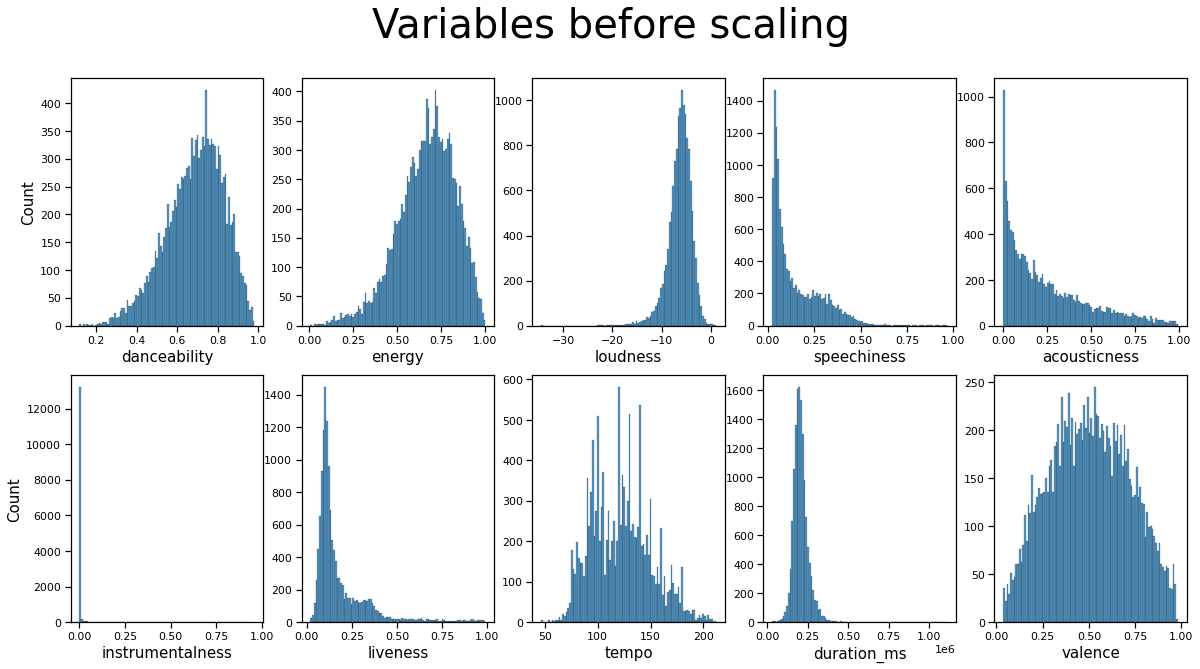

In [10]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
numerical = df.loc[:, ~df.columns.isin(('key',	'mode',	'time_signature'))].columns
lst = iter(numerical)

# Create histograms
fig, axes = plt.subplots(2, 5, figsize=(20, 10))


for triaxis in axes:
    for i, axis in enumerate(triaxis):
        try:
            b = sns.histplot(data = df, x=df[next(lst)], bins = 100, ax=axis)
            if i != 0:
                b.set_ylabel(None)
        except IndexError:
            break

fig.suptitle('Variables before scaling', fontsize=40)

_ = sns.reset_orig        

* Based on the info presented above we need to perform the following pre-poscessing steps:
1. Normalize numeric columns (['Loudness', 'Tempo']) 
2. One hot encode categorical columns* (['Key', 'Time Signature'])

\* 'Mode' is not mentioned since it already takes binary values

In [11]:
# standardize numeric columns by calculating the z-score of each value.
scaler = StandardScaler()
df[['loudness', 'tempo', 'duration_ms']] = scaler.fit_transform(df[['loudness', 'tempo', 'duration_ms']].to_numpy())

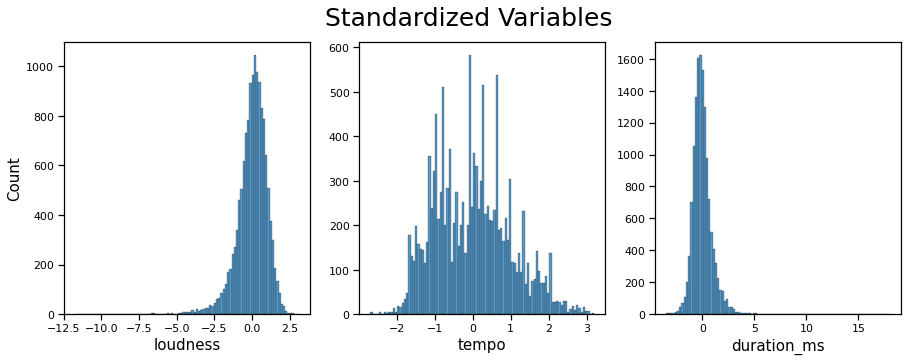

In [12]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
log_numerical = df.loc[:, df.columns.isin(('loudness', 'tempo', 'duration_ms'))].columns
lst = iter(log_numerical)

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i, axis in enumerate(axes):
    try:
        b = sns.histplot(data = df, x=df[next(lst)], bins = 100, ax=axis)
        if i != 0:
            b.set_ylabel(None)
    except IndexError:
        break

fig.suptitle('Standardized Variables', fontsize=25)

_ = sns.reset_orig   

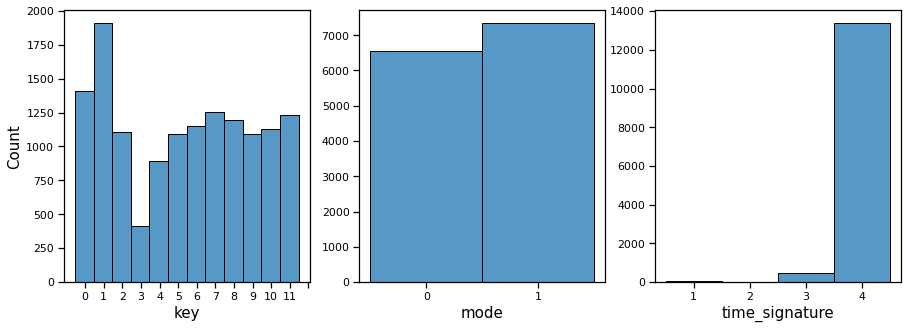

In [13]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":15})  

# Create columns iterator
categorical = df.loc[:, df.columns.isin(('key',	'mode',	'time_signature'))].columns
lst = iter(categorical)

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i, axis in enumerate(axes):
    try:
        col = next(lst)
        bin_num = len(df[col].value_counts())
        b = sns.histplot(data = df, x=col, bins=bin_num, ax=axis)
        
        # fix bin position
        if col == 'time_signature':
            
            b.set_xticks(np.arange(df[col].value_counts().keys().min()+0.5,bin_num+1, 1))
            b.set_xticklabels(np.arange(df[col].value_counts().keys().min(),bin_num+1, 1))
        elif col == 'key':
            b.set_xticklabels(np.arange(df[col].value_counts().keys().min(),bin_num, 1))
            b.set_xticks(np.arange(df[col].value_counts().keys().min()+0.5,bin_num, 0.915))
        else:
            b.set_xticks([0.25, 0.75])
            b.set_xticklabels([0,1])
        # keep only one 'count'
        if i != 0:
            b.set_ylabel(None)    
    except IndexError:
        break


_ = sns.reset_orig     

* Finally we will Create a correlation table

* Looks like energy and loudness are heavily correlated.

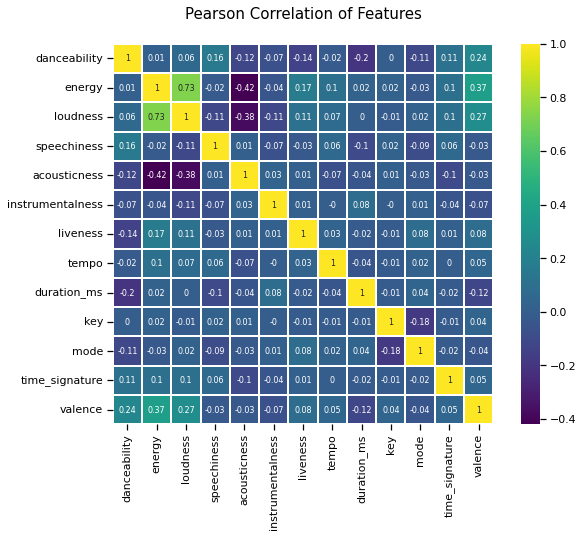

In [14]:
correlation_table(df)

### Run a Linear Regression using statsmodels

* If a categorical variable has $L$ distinct values (or levels), then statsmodels by default creates $L - 1$ *dummy* variables.

In [15]:
# Create the string to feed the regression model
all_columns = list(df.columns[:-4]) + [f"C({col})" for col in df.columns[-4:-1]]
all_columns_formula = f"valence ~ " + '+'.join(all_columns) 


# run the regression and print the summary
df_mod = smf.ols(all_columns_formula, data=df)
df_res = df_mod.fit()
df_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     184.4
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:49:56   Log-Likelihood:                 3596.1
No. Observations:               13880   AIC:                            -7142.
Df Residuals:                   13855   BIC:                            -6954.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1886      0.029     -6.433      0.000      -0.246      -0.131
C(key)[T.1]               -0.0252      0.007     -3.808      0.000      -0.038      -0.012
C(key)[T.2]               -0.0164      0.008     -2.181      0.029      -0.031      -0.002
C(key)[T.3]                0.0435      0.010      4.152      0.000       0.023       0.064
C(key)[T.4]               -0.0325      0.008     -4.027      0.000      -0.048      -0.017
C(key)[T.5]                0.0170      0.008      2.230      0.026       0.002       0.032
C(key)[T.6]                0.0131      0.007      1.751      0.080      -0.002       0.028
C(key)[T.7]               -0.0017      0.007     -0.231      0.818      -0.016       0.013
C(key)[T.8]                0.0042      0.007      0.567      0.570      -0.010       0.019
C(key)[T.9]                0.0040      0.008      0.526      0.599      -0.011       0.019
C(key)[T.10]              -0.0047      0.008     -0.623      0.533      -0.020       0.010
C(key)[T.11]               0.0182      0.007      2.468      0.014       0.004       0.033
C(mode)[T.1]               0.0072      0.003      2.126      0.033       0.001       0.014
C(time_signature)[T.3]    -0.0170      0.027     -0.623      0.533      -0.070       0.036
C(time_signature)[T.4]    -0.0321      0.026     -1.237      0.216      -0.083       0.019
C(time_signature)[T.5]     0.0052      0.028      0.188      0.851      -0.049       0.060
danceability               0.4152      0.012     33.472      0.000       0.391       0.440
energy                     0.6045      0.015     39.585      0.000       0.575       0.634
loudness                  -0.0056      0.002     -2.334      0.020      -0.010      -0.001
speechiness               -0.1178      0.013     -9.191      0.000      -0.143      -0.093
acousticness               0.1706      0.008     22.070      0.000       0.155       0.186
instrumentalness          -0.1606      0.027     -6.017      0.000      -0.213      -0.108
liveness                   0.0515      0.011      4.800      0.000       0.030       0.072
tempo                      0.0067      0.002      4.162      0.000       0.004       0.010
duration_ms               -0.0141      0.002     -8.602      0.000      -0.017      -0.011
==============================================================================
Omnibus:                      137.348   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.008
Skew:                           0.013   Prob(JB):                     7.75e-20
Kurtosis:                       2.611   Cond. No.                         60.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

### One hot encode (Using sklearn)

* It seems that some keys/time signatures could be excluded for the model, based on the p-values, which are higher than the typical significance levels (5%, 1%, 0,1%). It is worth noting here than the p-value signifies the minimum value in which the Null hypothesis (that the coefficients fo not play a significant role) is rejected. In order to verify that the 


* We will now proceed with one-hot encoding the categorical variables, since we want to exclude some of them. The originl dataframe (df) will be kept intact, since the one hot encoding we will prerform here will be different than the one needed for the ML part (prediction), and we will use a df_dummy for this part of the analysis.
* Note that `drop_first` is used here, since that is the standard when doing a statistical analysis.

In [16]:
df_dummy = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'], drop_first=True)

# Move valence column to the end
order = list(df_dummy.columns)
order.remove('valence')
order.append('valence')

# Re-order
df_dummy = df_dummy[order]

df_dummy.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key_1,...,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_3,time_signature_4,time_signature_5,valence
0,0.681,0.594,-0.304241,0.2820,0.1650,0.000003,0.134,2.266837,0.463644,0,...,1,0,0,0,0,1,0,1,0,0.5350
1,0.720,0.763,0.931311,0.0523,0.4060,0.000000,0.180,-0.725028,0.875433,0,...,0,0,1,0,0,0,0,1,0,0.7420
2,0.748,0.524,0.292247,0.0338,0.4140,0.000000,0.111,-0.972485,0.753143,0,...,0,1,0,0,0,1,0,1,0,0.6610
3,0.735,0.451,-0.866083,0.0585,0.0631,0.000013,0.325,-0.155467,0.757933,0,...,0,0,0,0,0,1,0,1,0,0.0862
4,0.670,0.838,0.946755,0.0362,0.0604,0.000611,0.159,-0.617115,0.295775,0,...,0,0,0,0,0,1,0,1,0,0.7170


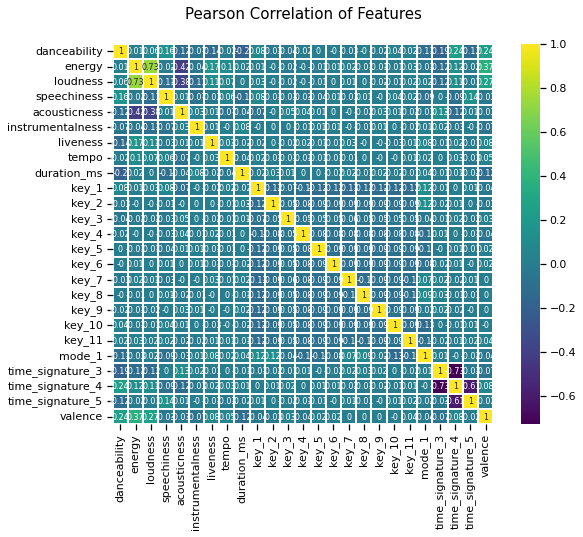

In [17]:
correlation_table(df_dummy)

* Let's run again the regression having created the dummy variables with sklearn, to verify we get the same results as the statsmodel default dummy variables way.

In [18]:
# repeat the porcess with the new dataframe to verify results
all_columns = list(df_dummy.columns[:-1])

# run the regression and print the summary
all_columns_formula = f"valence ~ " + '+'.join(all_columns) 
df_dummy_mod_full = smf.ols(all_columns_formula, data=df_dummy)
df_dummy_res_full = df_dummy_mod_full.fit()
df_dummy_res_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     184.4
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:50:07   Log-Likelihood:                 3596.1
No. Observations:               13880   AIC:                            -7142.
Df Residuals:                   13855   BIC:                            -6954.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1886      0.029     -6.433      0.000      -0.246      -0.131
danceability         0.4152      0.012     33.472      0.000       0.391       0.440
energy               0.6045      0.015     39.585      0.000       0.575       0.634
loudness            -0.0056      0.002     -2.334      0.020      -0.010      -0.001
speechiness         -0.1178      0.013     -9.191      0.000      -0.143      -0.093
acousticness         0.1706      0.008     22.070      0.000       0.155       0.186
instrumentalness    -0.1606      0.027     -6.017      0.000      -0.213      -0.108
liveness             0.0515      0.011      4.800      0.000       0.030       0.072
tempo                0.0067      0.002      4.162      0.000       0.004       0.010
duration_ms         -0.0141      0.002     -8.602      0.000      -0.017      -0.011
key_1               -0.0252      0.007     -3.808      0.000      -0.038      -0.012
key_2               -0.0164      0.008     -2.181      0.029      -0.031      -0.002
key_3                0.0435      0.010      4.152      0.000       0.023       0.064
key_4               -0.0325      0.008     -4.027      0.000      -0.048      -0.017
key_5                0.0170      0.008      2.230      0.026       0.002       0.032
key_6                0.0131      0.007      1.751      0.080      -0.002       0.028
key_7               -0.0017      0.007     -0.231      0.818      -0.016       0.013
key_8                0.0042      0.007      0.567      0.570      -0.010       0.019
key_9                0.0040      0.008      0.526      0.599      -0.011       0.019
key_10              -0.0047      0.008     -0.623      0.533      -0.020       0.010
key_11               0.0182      0.007      2.468      0.014       0.004       0.033
mode_1               0.0072      0.003      2.126      0.033       0.001       0.014
time_signature_3    -0.0170      0.027     -0.623      0.533      -0.070       0.036
time_signature_4    -0.0321      0.026     -1.237      0.216      -0.083       0.019
time_signature_5     0.0052      0.028      0.188      0.851      -0.049       0.060
==============================================================================
Omnibus:                      137.348   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.008
Skew:                           0.013   Prob(JB):                     7.75e-20
Kurtosis:                       2.611   Cond. No.                         60.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The results we hot match the ones we previously had (when statsmodel took care of the dummy variable assigmnent)

* We will now remove the columns with a p-value above the typical significance level of 5% and run the linear regression once more. 

In [19]:
col_reduced = all_columns
col_reduced = [i for i in col_reduced if i not in ['key_7', 'key_8', 'key_9', 'key_10', 'time_signature_3', 
                            'time_signature_4', 'time_signature_5']]

# run the regression and print the summary
col_reduced_formula = f"valence ~ " + '+'.join(col_reduced)  
df_dummy_mod = smf.ols(col_reduced_formula, data=df_dummy)
df_dummy_res = df_dummy_mod.fit()
df_dummy_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     259.2
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:50:10   Log-Likelihood:                 3587.7
No. Observations:               13880   AIC:                            -7139.
Df Residuals:                   13862   BIC:                            -7004.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2095      0.015    -14.368      0.000      -0.238      -0.181
danceability         0.4035      0.012     33.723      0.000       0.380       0.427
energy               0.6009      0.015     39.447      0.000       0.571       0.631
loudness            -0.0054      0.002     -2.222      0.026      -0.010      -0.001
speechiness         -0.1098      0.013     -8.694      0.000      -0.135      -0.085
acousticness         0.1711      0.008     22.189      0.000       0.156       0.186
instrumentalness    -0.1585      0.027     -5.941      0.000      -0.211      -0.106
liveness             0.0498      0.011      4.648      0.000       0.029       0.071
tempo                0.0064      0.002      3.989      0.000       0.003       0.010
duration_ms         -0.0144      0.002     -8.786      0.000      -0.018      -0.011
key_1               -0.0254      0.005     -5.126      0.000      -0.035      -0.016
key_2               -0.0171      0.006     -2.785      0.005      -0.029      -0.005
key_3                0.0422      0.009      4.448      0.000       0.024       0.061
key_4               -0.0332      0.007     -4.907      0.000      -0.046      -0.020
key_5                0.0165      0.006      2.661      0.008       0.004       0.029
key_6                0.0126      0.006      2.085      0.037       0.001       0.024
key_11               0.0180      0.006      3.065      0.002       0.006       0.030
mode_1               0.0074      0.003      2.204      0.028       0.001       0.014
==============================================================================
Omnibus:                      139.519   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.107
Skew:                           0.013   Prob(JB):                     4.47e-20
Kurtosis:                       2.608   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA

* We can check if the two models fit the data equally well ot if  the reduced model fit is better than the full model fit using ANOVA.

* The null hypothesis is that the two models fit the data equally well, while the alternative hypothesis is that the full model model is superior.

* Based on the p-value, we reject the Null hypothesis, thus we consider the full model to git the data better than the reduced one.

In [20]:
table = sm.stats.anova_lm(df_dummy_res, df_dummy_res_full)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,13862.0,484.622429,0.0,NaN,NaN,NaN
1,13855.0,484.032861,7.0,0.589568,2.410835,0.018263


<br><br>
### Best variable model selection using step-wise methods

* In searching for the "best" possible sub-model in multiple linear regression, one can use stepwise methods, which are algorithmic methods that come with a proposal of the "best" sub-model.
<br/><br/>
* The most popular stepwise methods are:
    - Backward Elimination
    - Forward Selection
    - Stepwise Regression

### Forward stepwise selection

* We start with picking the best model with one variable.

* We find the best model with two variables by adding one variable.

* We find the best model with three variables by adding another variable, and so on.

* This is *not* guaranteed to find the best model overall.

* We use the `forward_add_variable()` found in the `stats_function.py` file to find the best variable to add at each step.

In [21]:
# find the best model with forward selection
best_model_fw, best_models_fw = forward_stepwise_selection(df_dummy, 'valence')
print('Best overall model:', len(best_model_fw.model.exog_names), best_model_fw.model.exog_names)

Fitted 326 models
Best overall model: 20 ['intercept', 'energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4', 'instrumentalness', 'liveness', 'key_3', 'tempo', 'key_2', 'time_signature_4', 'key_11', 'key_5', 'loudness', 'mode_1', 'key_6', 'time_signature_3']


In [22]:
best_model_fw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:50:28   Log-Likelihood:                 3595.2
No. Observations:               13880   AIC:                            -7150.
Df Residuals:                   13860   BIC:                            -7000.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.1844      0.017    -11.023      0.000      -0.217      -0.152
energy               0.6047      0.015     39.622      0.000       0.575       0.635
danceability         0.4151      0.012     33.481      0.000       0.391       0.439
acousticness         0.1706      0.008     22.082      0.000       0.155       0.186
duration_ms         -0.0141      0.002     -8.605      0.000      -0.017      -0.011
speechiness         -0.1177      0.013     -9.198      0.000      -0.143      -0.093
key_1               -0.0255      0.005     -5.149      0.000      -0.035      -0.016
key_4               -0.0327      0.007     -4.848      0.000      -0.046      -0.020
instrumentalness    -0.1608      0.027     -6.029      0.000      -0.213      -0.109
liveness             0.0514      0.011      4.794      0.000       0.030       0.072
key_3                0.0432      0.009      4.548      0.000       0.025       0.062
tempo                0.0067      0.002      4.166      0.000       0.004       0.010
key_2               -0.0168      0.006     -2.732      0.006      -0.029      -0.005
time_signature_4    -0.0363      0.010     -3.603      0.000      -0.056      -0.017
key_11               0.0180      0.006      3.056      0.002       0.006       0.029
key_5                0.0167      0.006      2.706      0.007       0.005       0.029
loudness            -0.0056      0.002     -2.342      0.019      -0.010      -0.001
mode_1               0.0077      0.003      2.292      0.022       0.001       0.014
key_6                0.0129      0.006      2.130      0.033       0.001       0.025
time_signature_3    -0.0210      0.013     -1.592      0.111      -0.047       0.005
==============================================================================
Omnibus:                      136.562   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.641
Skew:                           0.014   Prob(JB):                     9.31e-20
Kurtosis:                       2.612   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

20


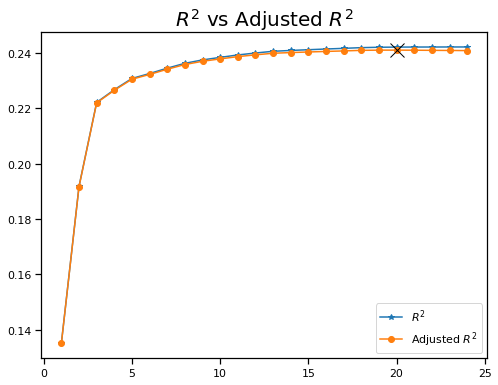

In [23]:
plot_model_selection(best_models_fw, best_model_fw)

### Backward Elimination selection

* Alternatively, if the number of independent variables is large, then we can do *backward stepwise selection*.

* We start with picking the best model with all $p$ variables.

* We find the best model with $p - 1$ variables by removing one variable.

* We find the best model with $p - 2$ variables by removing another variable, and so on.

* Again, this is *not* guaranteed to find the best model overall.

* We use the `forward_adbackward_remove_variabled_variable()`, found in the `stats_function.py` file, to find the best variable to remove at each step.

In [24]:
best_model_bw, best_models_bw = backward_stepwise_selection(df_dummy, 'valence')
print('Best overall model:', len(best_model_bw.model.exog_names), best_model_bw.model.exog_names)

Fitted 326 models
Best overall model: 20 ['intercept', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_11', 'mode_1', 'time_signature_3', 'time_signature_4']


In [25]:
best_model_bw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:50:36   Log-Likelihood:                 3595.2
No. Observations:               13880   AIC:                            -7150.
Df Residuals:                   13860   BIC:                            -7000.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.1844      0.017    -11.023      0.000      -0.217      -0.152
danceability         0.4151      0.012     33.481      0.000       0.391       0.439
energy               0.6047      0.015     39.622      0.000       0.575       0.635
loudness            -0.0056      0.002     -2.342      0.019      -0.010      -0.001
speechiness         -0.1177      0.013     -9.198      0.000      -0.143      -0.093
acousticness         0.1706      0.008     22.082      0.000       0.155       0.186
instrumentalness    -0.1608      0.027     -6.029      0.000      -0.213      -0.109
liveness             0.0514      0.011      4.794      0.000       0.030       0.072
tempo                0.0067      0.002      4.166      0.000       0.004       0.010
duration_ms         -0.0141      0.002     -8.605      0.000      -0.017      -0.011
key_1               -0.0255      0.005     -5.149      0.000      -0.035      -0.016
key_2               -0.0168      0.006     -2.732      0.006      -0.029      -0.005
key_3                0.0432      0.009      4.548      0.000       0.025       0.062
key_4               -0.0327      0.007     -4.848      0.000      -0.046      -0.020
key_5                0.0167      0.006      2.706      0.007       0.005       0.029
key_6                0.0129      0.006      2.130      0.033       0.001       0.025
key_11               0.0180      0.006      3.056      0.002       0.006       0.029
mode_1               0.0077      0.003      2.292      0.022       0.001       0.014
time_signature_3    -0.0210      0.013     -1.592      0.111      -0.047       0.005
time_signature_4    -0.0363      0.010     -3.603      0.000      -0.056      -0.017
==============================================================================
Omnibus:                      136.562   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.641
Skew:                           0.014   Prob(JB):                     9.31e-20
Kurtosis:                       2.612   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

20


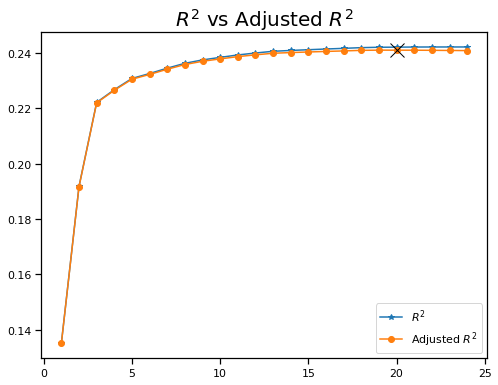

In [26]:
plot_model_selection(best_models_bw, best_model_bw, reverse=True)

### Check results vs AIC, BIC

* Usually in statistics, stepwise regression is performed using AIC. 
* Since we used the Adjusted $R^2$ for our stepwise selection, we will evaludate the results against the AIC. 
* Want we are expecting is the find the best $R^2$ value where the AIC is small.

* As shown below the AIC is getting smaller as the Adjusted $R^2$ is getting bigger, which means that the stepwise method worked as expected.
* On the other hand the BIC seems to be a little bit higher in the selected $R^2$, but since the parameter selection is performed with either AIC or BIC we will accept the results based on the AIC criterion.

20


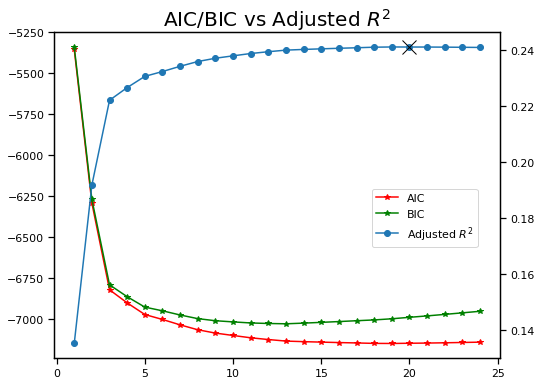

In [27]:
plot_model_AIC(best_models_bw, best_model_bw, reverse=True)

### Improve using Interaction terms

* We can introduce interaction terms in order to further improve the results. <br>
*Since many terms were tested we only show the best results.

In [28]:
# define columns based on best model so far
cols = list(best_model_bw.params.keys())
cols.remove('intercept')
cols.remove('time_signature_3')


# run the regression and print the summary with interaction terms
col_reduced_formula = f"valence ~ " + '+'.join(cols) + ' + energy*loudness   + energy*speechiness + energy*duration_ms  + acousticness*duration_ms\
            + danceability*speechiness + loudness*danceability + duration_ms*tempo + loudness*duration_ms  + speechiness*tempo \
            + speechiness*loudness + liveness*danceability + duration_ms*liveness + liveness*loudness + acousticness*speechiness'


df_inter_mod = smf.ols(col_reduced_formula, data=df_dummy)
df_inter_res = df_inter_mod.fit()
df_inter_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     148.2
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:50:47   Log-Likelihood:                 3715.5
No. Observations:               13880   AIC:                            -7365.
Df Residuals:                   13847   BIC:                            -7116.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.3572      0.023    -15.545      0.000      -0.402      -0.312
danceability                 0.5383      0.023     23.262      0.000       0.493       0.584
energy                       0.6975      0.022     31.318      0.000       0.654       0.741
loudness                    -0.0466      0.008     -6.147      0.000      -0.061      -0.032
speechiness                  0.8455      0.110      7.676      0.000       0.630       1.061
acousticness                 0.2017      0.012     17.184      0.000       0.179       0.225
instrumentalness            -0.1903      0.027     -7.111      0.000      -0.243      -0.138
liveness                     0.1573      0.051      3.103      0.002       0.058       0.257
tempo                        0.0131      0.003      5.119      0.000       0.008       0.018
duration_ms                 -0.0431      0.011     -4.105      0.000      -0.064      -0.023
key_1                       -0.0256      0.005     -5.201      0.000      -0.035      -0.016
key_2                       -0.0157      0.006     -2.585      0.010      -0.028      -0.004
key_3                        0.0451      0.009      4.782      0.000       0.027       0.064
key_4                       -0.0305      0.007     -4.551      0.000      -0.044      -0.017
key_5                        0.0169      0.006      2.764      0.006       0.005       0.029
key_6                        0.0131      0.006      2.192      0.028       0.001       0.025
key_11                       0.0175      0.006      3.005      0.003       0.006       0.029
mode_1                       0.0075      0.003      2.250      0.024       0.001       0.014
time_signature_4            -0.0214      0.007     -3.027      0.002      -0.035      -0.008
energy:loudness              0.0520      0.008      6.879      0.000       0.037       0.067
energy:speechiness          -0.7593      0.109     -6.937      0.000      -0.974      -0.545
energy:duration_ms           0.0619      0.014      4.327      0.000       0.034       0.090
acousticness:duration_ms    -0.0242      0.007     -3.399      0.001      -0.038      -0.010
danceability:speechiness    -0.5763      0.093     -6.217      0.000      -0.758      -0.395
loudness:danceability        0.0239      0.010      2.288      0.022       0.003       0.044
duration_ms:tempo           -0.0072      0.002     -4.658      0.000      -0.010      -0.004
loudness:duration_ms        -0.0058      0.002     -2.828      0.005      -0.010      -0.002
speechiness:tempo           -0.0365      0.011     -3.279      0.001      -0.058      -0.015
speechiness:loudness         0.0269      0.014      1.973      0.049       0.000       0.054
liveness:danceability       -0.1684      0.077     -2.197      0.028      -0.319      -0.018
duration_ms:li

## Section 1 conclusion

| Model        | Adjusted $R^2$ |  AIC        
| ------------- |:--------------:|:--------------:|
| Full model     | 0.241 |  -7142.27 |
| p-value opt     | 0.240       | -7139.28 |
| Forward Selection | 0.241       | -7150.36|
| Backward Elimination | 0.241       | -7150.36|
| **Backward Elimination + interaction terms**| 0.253       | -7365.07|

* We started having the full model with the full model which has the following parameters:

In [29]:
print(f"Full Model: Adjusted R_squared: {df_dummy_res_full.rsquared_adj:.3f}, AIC: {df_dummy_res_full.aic:.2f}", end = '\n\n')
print("Full Model parameters:")
_ = [print(i, end = ', ') for i in sorted(df_dummy_res_full.params.keys())]

Full Model: Adjusted R_squared: 0.241, AIC: -7142.26

Full Model parameters:
Intercept, acousticness, danceability, duration_ms, energy, instrumentalness, key_1, key_10, key_11, key_2, key_3, key_4, key_5, key_6, key_7, key_8, key_9, liveness, loudness, mode_1, speechiness, tempo, time_signature_3, time_signature_4, time_signature_5, 

* We then used three different methods to get better results. 
* The parameters that were removed from the full model, along with the corresponding $R^2$ and AIC  can be found below.

In [30]:

for i, string in zip([df_dummy_res, best_model_fw, best_model_bw, df_inter_res], 
                                    ['Parameters removed using the p-value optimization method:', "Parameters removed using Forward Selection:",
                                            "Parameters removed using Backward Elimination:", "Parameters removed using Forward Selection with added interaction terms:"]):
    print(string)
    _ = [print(par, end = ', ') for par in sorted(df_dummy_res_full.params.keys()) if par not in i.params.keys() and par != 'Intercept']    
    print(f"\nAdjusted R_squared: {i.rsquared_adj:.3f}, AIC: {i.aic:.2f}")
    print('\n'*2)                                        

Parameters removed using the p-value optimization method:
key_10, key_7, key_8, key_9, time_signature_3, time_signature_4, time_signature_5, 
Adjusted R_squared: 0.240, AIC: -7139.36



Parameters removed using Forward Selection:
key_10, key_7, key_8, key_9, time_signature_5, 
Adjusted R_squared: 0.241, AIC: -7150.35



Parameters removed using Backward Elimination:
key_10, key_7, key_8, key_9, time_signature_5, 
Adjusted R_squared: 0.241, AIC: -7150.35



Parameters removed using Forward Selection with added interaction terms:
key_10, key_7, key_8, key_9, time_signature_3, time_signature_5, 
Adjusted R_squared: 0.253, AIC: -7365.07





<a id='section_2'></a>
# Section 2: Predict Valence

We will use Machine Learning techniques to predict valence based on track features. Rules:

* Use at least three different methods. For each method, ensure thatthe hyperparameters are tunes to the best result possible.

* Once the best method and hyperparameters are identified, explain, to the extent that is possible, which features influence the valence metric.

* Evaluate predictions on a holdout 20% testing dataset.

*It is recommended to restart the kernel at this point before proceeding.

In [1]:
# Import libraries needed for this part to be independent of the other parts
import pandas as pd
import numpy as np

import re
import os
import itertools
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from keras.regularizers import l2

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cb
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Define Functions 

* This part loads the functions that we are going to use in this analysis. These are found in the `helper_functions.py` file.

In [2]:
from helper_functions import *

## Load the Data

* Read Dataframes from the files, since this senction is independent. Please note that the [Appendix 2](#appendix_2) is needed before proceeding.

In [3]:
# Train DF
try:
    df_ml = pd.read_csv('./audio_features_extra.csv')
    print('Reading Train DataFrame from file')
    df_ml = df_ml.append(pd.read_csv('./audio_features_spotify_search.csv'))
    print('Reading Train (Extra) DataFrame from file')
    df_ml = df_ml.append(pd.read_csv('./audio_features_spotify_scrap.csv'))
    print('Reading Train (Scrap) DataFrame from file')
except:
    print('Please run the "Download the top-streaming songs of the 2017-2019 period" and "Appendix 2" section to generate the dataframes.')

Reading Train DataFrame from file
Reading Train (Extra) DataFrame from file
Reading Train (Scrap) DataFrame from file


In [4]:
# Remove duplicates and dropna
df_ml.dropna(inplace=True)
df_ml.drop_duplicates(inplace=True)
df_ml.reset_index(inplace=True)
df_ml.shape

(97001, 53)

In [5]:
df_ml = pre_processing(df_ml)
df_ml.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,tempo_confidence,duration_ms,...,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,key,mode,time_signature,valence
0,0.681,0.594,-7.028,0.2820,0.1650,0.000003,0.134,186.054,0.165,230453,...,1.514876,-2.376809,0.656761,5.700232,-18.592179,-1.092454,7,1,4,0.5350
1,0.720,0.763,-4.068,0.0523,0.4060,0.000000,0.180,101.965,0.460,251088,...,-1.474704,1.482797,-7.830749,3.769064,-12.888112,0.881602,9,0,4,0.7420
2,0.748,0.524,-5.599,0.0338,0.4140,0.000000,0.111,95.010,0.314,244960,...,-13.422538,-4.113714,-10.971919,-1.160414,-14.684009,1.395501,8,1,4,0.6610
3,0.735,0.451,-8.374,0.0585,0.0631,0.000013,0.325,117.973,0.750,245200,...,20.243924,8.294884,-1.146117,3.245916,-17.540552,0.038808,0,1,4,0.0862
4,0.670,0.838,-4.031,0.0362,0.0604,0.000611,0.159,104.998,0.768,222041,...,-15.529416,1.743342,-4.321017,7.561803,-12.431474,-5.487772,0,1,4,0.7170


In [6]:
# Test DF
try:
    test_df = pd.read_csv('./test_df.csv')
    print('Reading Test DataFrame from file')
except:
    if test_df is not None:
        print('Test DataFrame Exists')
    else:
        print('Please run the first part to generate the DataFrame')


Reading Test DataFrame from file


In [7]:
test_df = pre_processing(test_df)
test_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,tempo_confidence,duration_ms,...,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,key,mode,time_signature,valence
0,0.585,0.436,-8.761,0.0601,0.72100,0.000013,0.1050,143.874,0.252,242014,...,-0.111490,-0.116343,-2.815301,-2.546181,-9.382599,3.806793,10,1,4,0.132
1,0.680,0.826,-5.487,0.0309,0.02120,0.000012,0.5430,118.051,0.857,215627,...,3.210723,-6.942141,-7.276782,-3.543406,-9.379946,-2.194406,0,1,4,0.644
2,0.514,0.730,-5.934,0.0598,0.00146,0.000095,0.0897,171.005,0.875,200040,...,7.383236,-0.745243,8.223896,2.743308,-12.995984,-0.989638,1,1,4,0.334
3,0.731,0.573,-10.059,0.0544,0.40100,0.000052,0.1130,109.928,0.166,205090,...,18.525245,8.093477,-0.432036,0.537412,-13.412574,-7.004807,4,0,4,0.145
4,0.907,0.393,-7.636,0.0539,0.45100,0.000001,0.1350,104.949,0.544,205458,...,-2.818465,-14.925499,1.476694,2.807862,-21.408289,4.122929,4,0,4,0.202


## Clustering

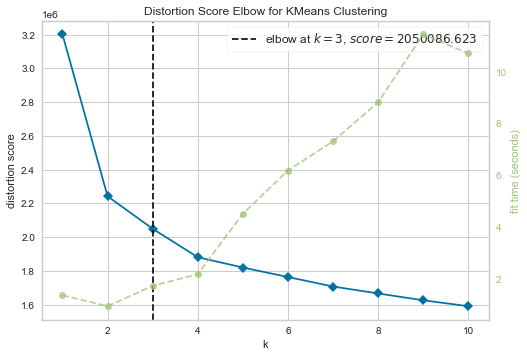

In [6]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(normalize(df_ml).iloc[:,:-1])
_ = visualizer.show()


* After testing clustering the data didn't seem to imperove the results, Thus the next part is commented out.

In [ ]:
# # Add the labels to the training dataset
# df_ml['cluster'] = visualizer.labels_
# order = list(df_ml.columns)
# order.remove('valence')
# order.append('valence')
# df_ml = df_ml[order]

# # Add cluster labels to the Test Dataseet
# test_clusters = visualizer.predict(normalize(test_df).iloc[:,:-1])
# test_df['cluster'] = test_clusters
# order = list(test_df.columns)
# order.remove('valence')
# order.append('valence')
# test_df = test_df[order]

## Train test split
* Assign the train and test variables

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_ml.iloc[:,:-1], df_ml.iloc[:,-1], random_state=42)


## Histogram

* lets visualize the two dataframes

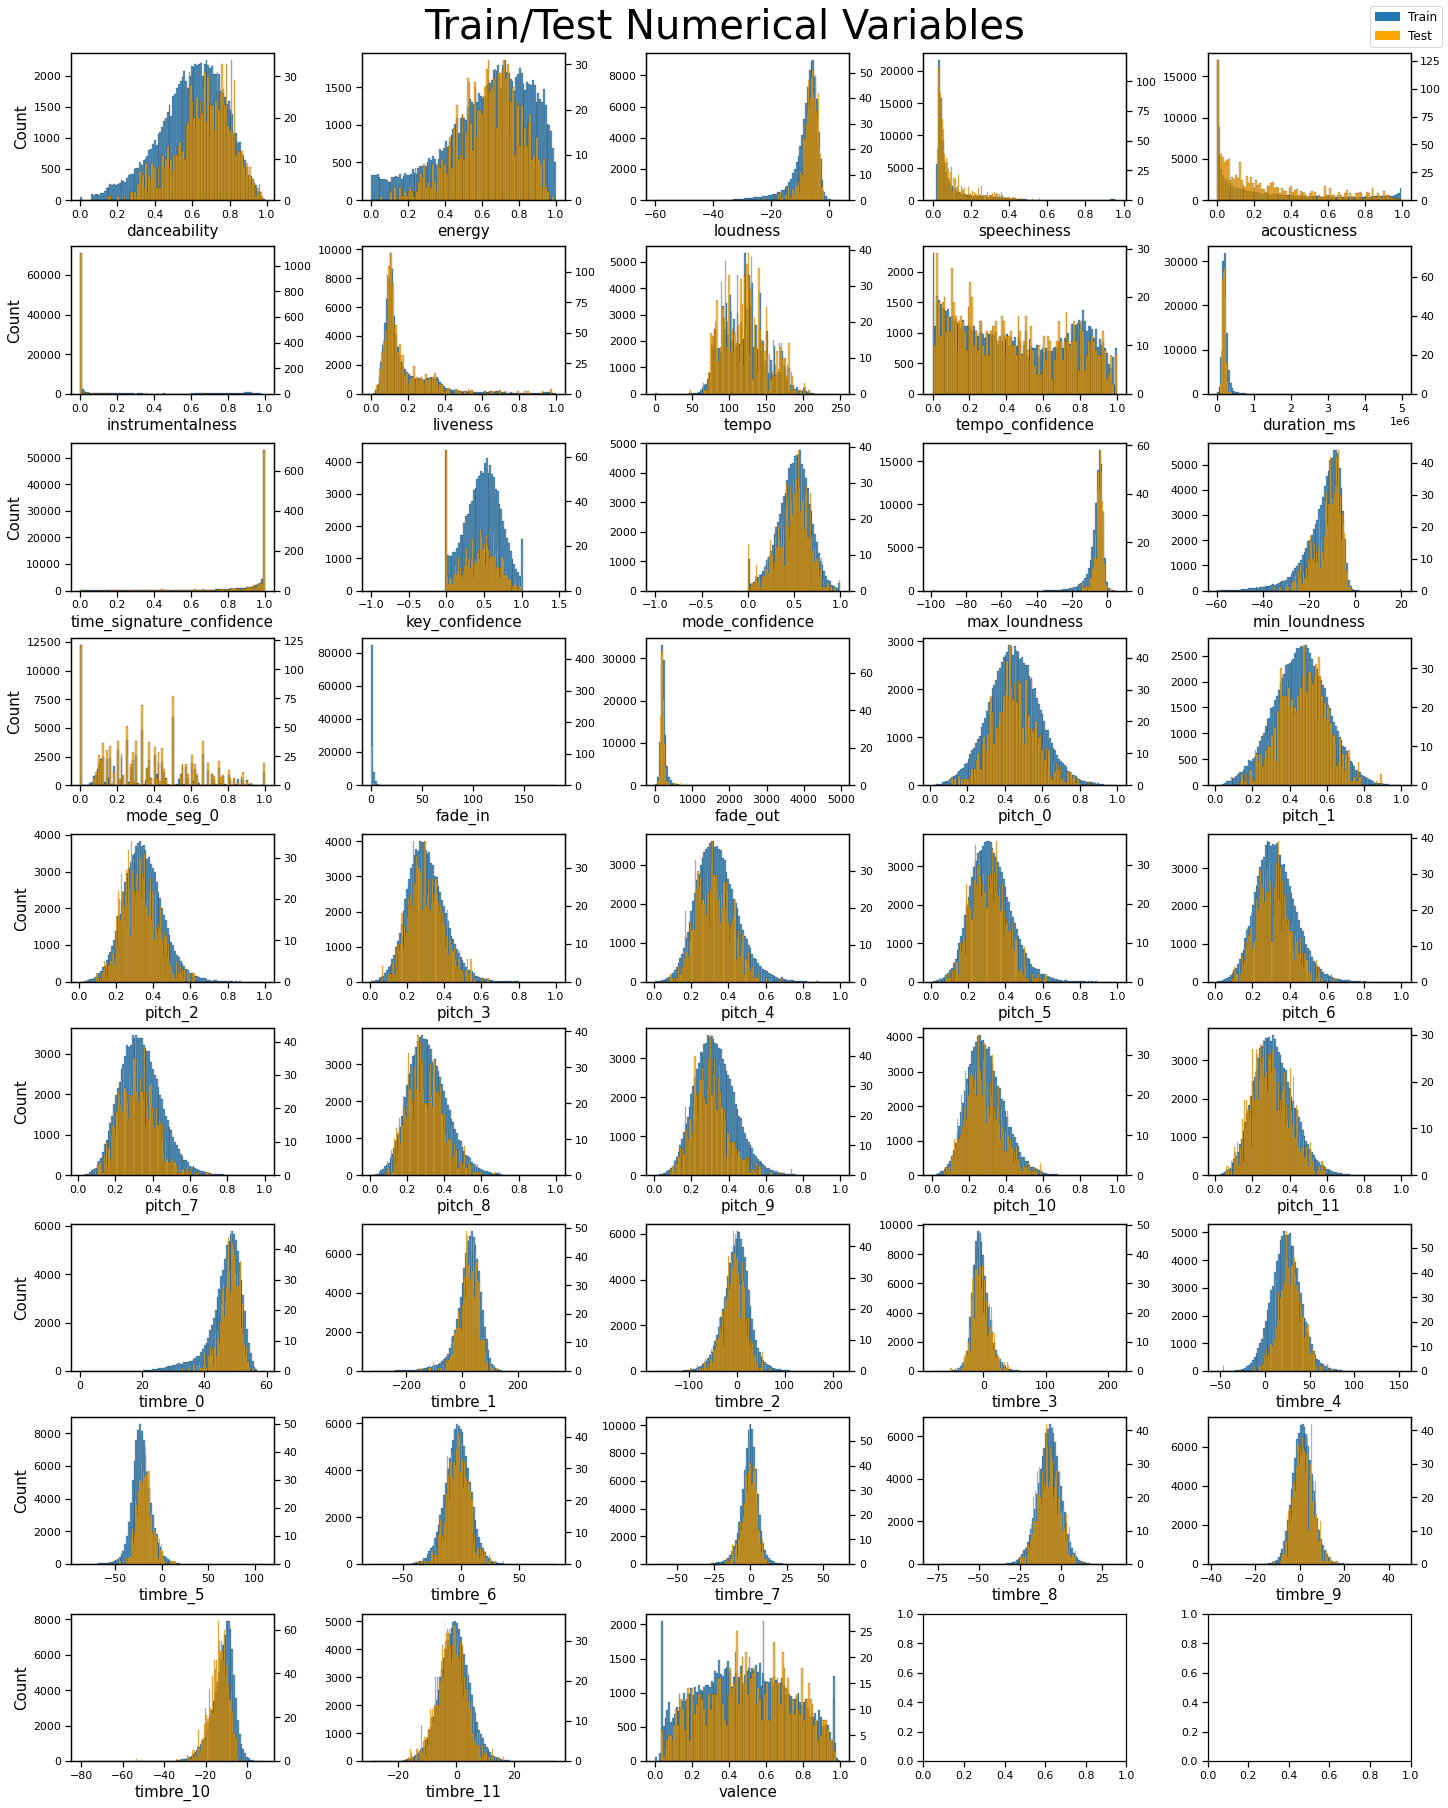

In [8]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
numerical = test_df.loc[:, ~test_df.columns.isin(('key', 'mode', 'time_signature'))].columns
lst = iter(numerical)

# Create histograms
fig, axes = plt.subplots(9, 5, figsize=(20, 25), constrained_layout=True)


for triaxis in axes:
    for i, axis in enumerate(triaxis):

        try:
            col = next(lst)
            b = sns.histplot(data = df_ml, x=df_ml[col], bins = 100, ax=axis)
            ax2 = axis.twinx()
            a = sns.histplot(data = test_df, x=test_df[col], bins = 100, ax=ax2, color='orange')
            a.set_ylabel(None)
            if i != 0:
                b.set_ylabel(None)
        except:
            break

# Title
fig.suptitle('Train/Test Numerical Variables', fontsize=40)

# Define Legens
train_legend = mpatches.Patch(color='#1f77b4', label='Train')
test_legend = mpatches.Patch(color='orange', label='Test')
fig.legend(handles=[train_legend,test_legend], prop={'size': 12})

# reset styling
_ = sns.reset_orig   

## Get initial scores

* After testing multiple models using [`Pyracet`](https://pycaret.org/) we got the top performing models. More info may be found in [Appendix 1](#pycaret)

* Using the top performing data we got a first estimation of the performance using a function which also using varying train sample size.
Looking at the results, it seems that CatBoost looks promessing, followed by XGBoost and finally ExtraTrees.

* That said, if we include the entire dataset (all 100k smaples) the results might be different.

In [10]:
# Initialize the three models
clf_A = cb.CatBoostRegressor(loss_function='RMSE', verbose=False)
clf_B = ExtraTreesRegressor()
clf_C = XGBRegressor()


# Calculate the number of samples for 20%, 40%, and 100% of the training data
samples_100 = len(y_train)
samples_40 = int(len(y_train)*0.4)
samples_20 = int(len(y_train)*0.2)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_20, samples_40, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


 
    

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CatBoostRegressor trained on 14550 samples.
CatBoostRegressor trained on 29100 samples.
CatBoostRegressor trained on 72750 samples.
ExtraTreesRegressor trained on 14550 samples.
ExtraTreesRegressor trained on 29100 samples.
ExtraTreesRegressor trained on 72750 samples.
XGBRegressor trained on 14550 samples.
XGBRegressor trained on 29100 samples.
XGBRegressor trained on 72750 samples.


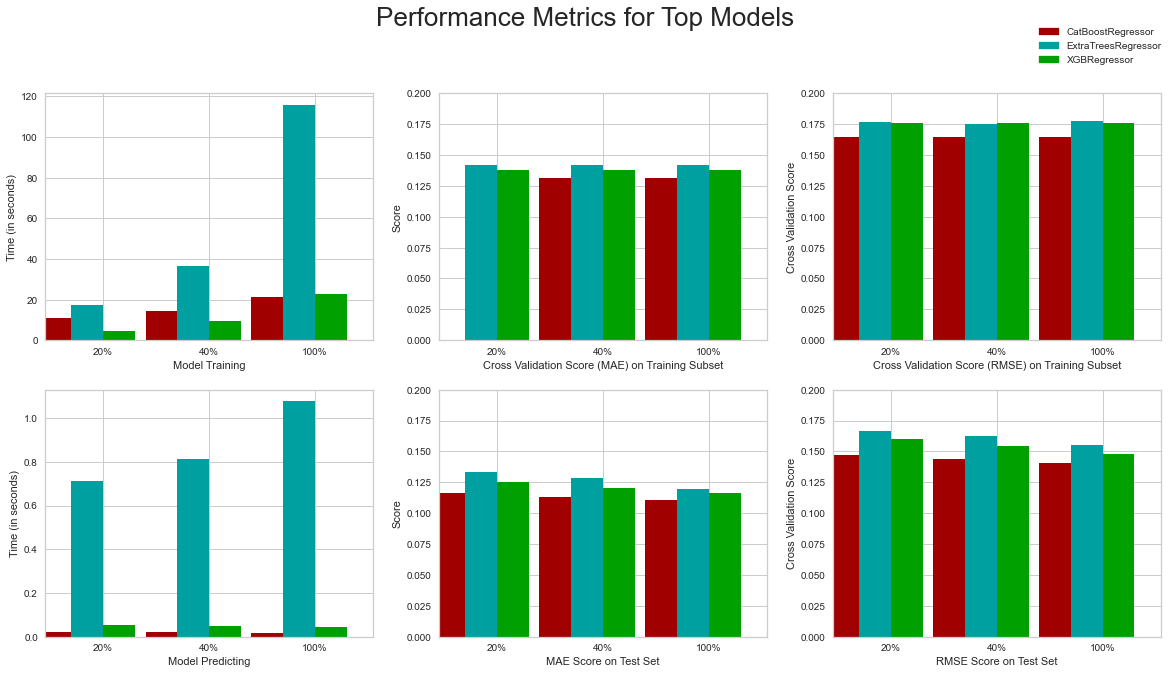

CatBoostRegressor Test MAE: 0.110
CatBoostRegressor Cross Validation score: 0.131
ExtraTreesRegressor Test MAE: 0.120
ExtraTreesRegressor Cross Validation score: 0.142
XGBRegressor Test MAE: 0.116
XGBRegressor Cross Validation score: 0.138


In [13]:
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)
for model in results:
    print("{} Test MAE: {:4.3f}".format(model,results[model][2]['mae_test']))
    print("{} Cross Validation score: {:4.3f}".format(model,results[model][2]['cross_val_mae_train']))  

## Optimization

* We will try to optimize the models to get a better score, before making the final predictions.

* For the optimization we will try randomized searches. 

### Extra Trees Regressor

The following cell was excecuted in order to see if the base ExtraTreesRegressionModel could be improved

In [ ]:
# random_grid = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor(random_state = 42)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.best_estimator_

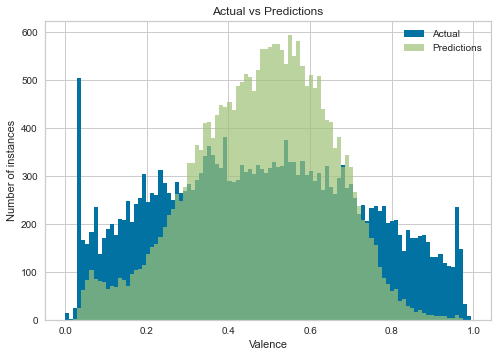

(0.11914332818935314, 0.023704143613594738, 0.0031814056789411)

In [9]:
# Best model
et = ExtraTreesRegressor(random_state=123, n_estimators=500)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)
compare_predictions(y_test, pred_et)
mean_absolute_error(pred_et, y_test) , mean_squared_error(pred_et, y_test),  (pred_et-y_test).mean() 

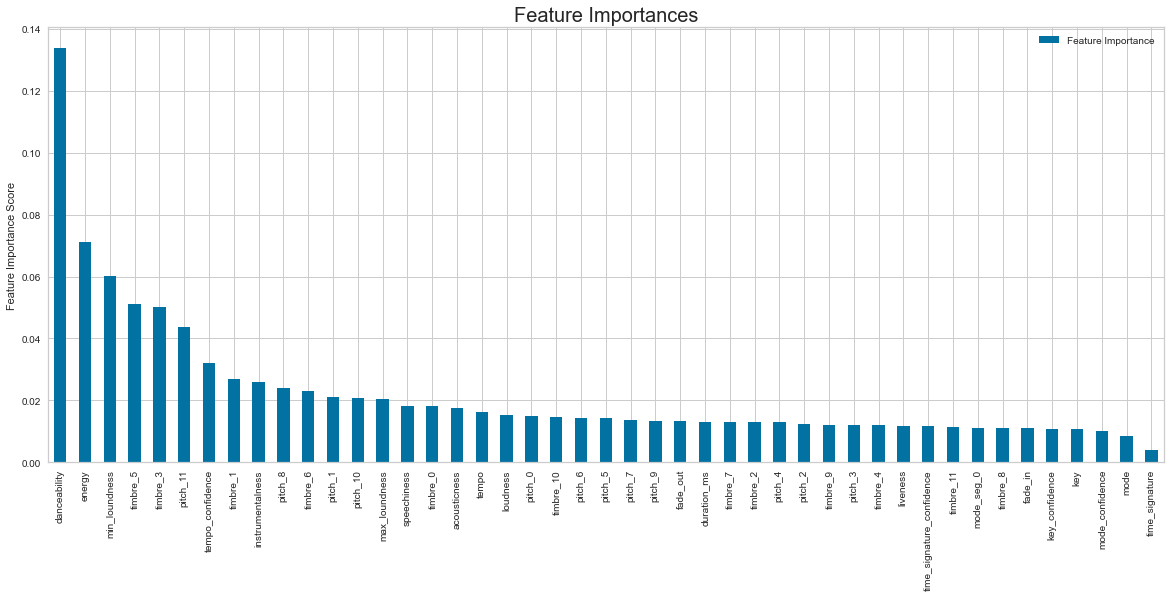

In [11]:
plot_model_var_imp(clf, X_train)


## XGBOOST

* The following part was excecuted in order to find the best parameters. Since it takes more than two hours to excecute it is commented out.

In [29]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dvalid = xgb.DMatrix(X_test, label=y_test)
# # dtest = xgb.DMatrix(test[feature_names].values)
# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# # small: min_child_weight, eta
# # large: subsample
# xgb_pars = []
# for MCW in [10, 20, 50, 75, 100]:
#     for ETA in [0.05, 0.1, 0.15]:
#         for CS in [0.3, 0.4, 0.5]:
#             for MD in [6, 8, 10, 12, 15]:
#                 for SS in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
#                     for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
#                         xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
#                                          'colsample_bytree': CS, 'max_depth': MD,
#                                          'subsample': SS, 'lambda': LAMBDA, 
#                                          'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'mae',
#                                          'objective': 'reg:squarederror', 'seed' :42})
# top_score = 1 
# for _ in range(50):
#     xgb_par = np.random.choice(xgb_pars, 1)[0]
#     print(xgb_par)
#     model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
#                       maximize=False, verbose_eval=100)
#     print('Modeling RMSLE %.5f' % model.best_score)
#     if model.best_score < top_score:
#         top_score = model.best_score
#         top_pars = xgb_par

# print(f"Top score is: {top_score}")
# print(xgb_par)

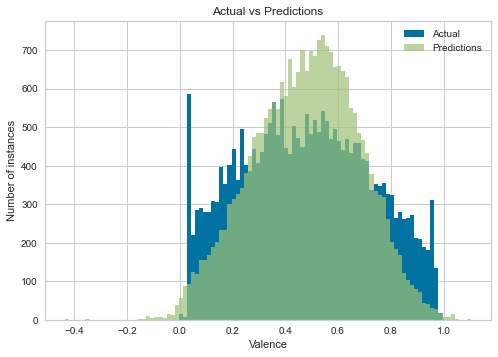

(0.11600323599489083, 0.02187252631473837, 0.0007624291596575079)

In [12]:
pars = {'min_child_weight': 50, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 10, 'subsample': 0.7, 
        'lambda': 1.5, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'seed': 42}

xgb_best = XGBRegressor()
xgb_best.fit(X_train, y_train)
pred_xgb = xgb_best.predict(X_test)
compare_predictions(y_test, pred_xgb)
mean_absolute_error(pred_xgb, y_test) , mean_squared_error(pred_xgb, y_test),  (pred_xgb-y_test).mean()

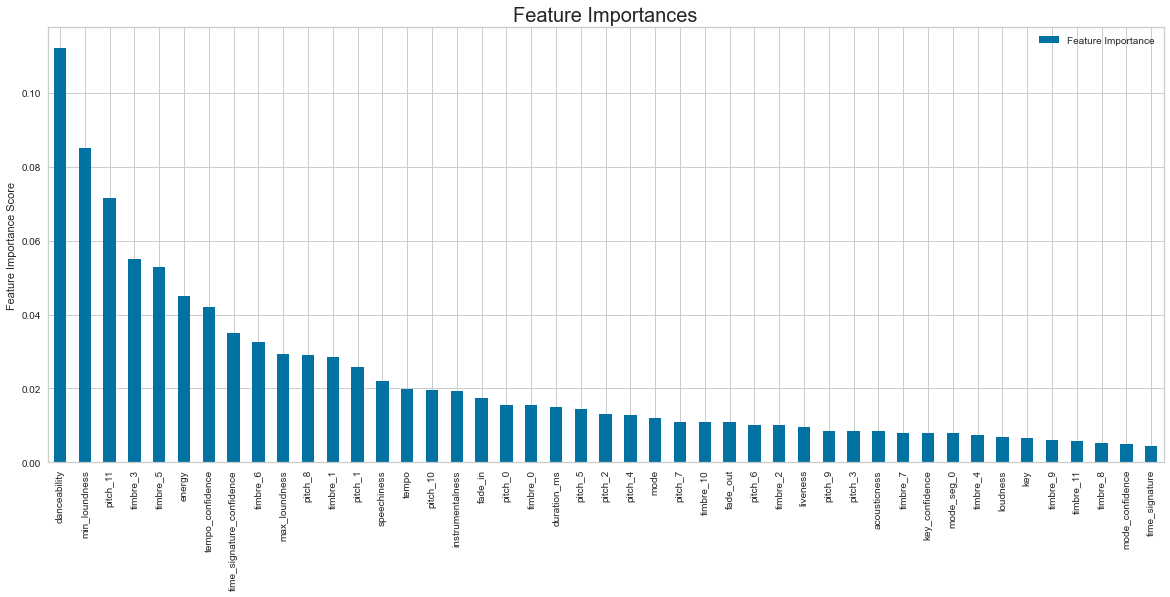

In [13]:
plot_model_var_imp(xgb_best, X_train)

## Catboost

In [14]:
# cat_model  = CatBoostRegressor(verbose=0, random_seed=42)

# params = {'iterations': [None, 30, 50, 100, 150, 200],
#         'learning_rate': [None, 0.01, 0.05, 0.1],
#         'depth': [None, 2, 4, 6, 8],
#         'l2_leaf_reg': [None, 0.2, 0.5, 1, 3]
#         }
# grid = GridSearchCV(cat_model, params, cv = 2, n_jobs=-1, verbose=2)
# grid.fit(X_train, y_train)

# pred_best_cat_model = grid.predict(X_test)
# compare_predictions(y_test, pred_best_cat_model)
# mean_absolute_error(pred_best_cat_model, y_test) , mean_squared_error(pred_best_cat_model, y_test),  (pred_best_cat_model-y_test).mean()

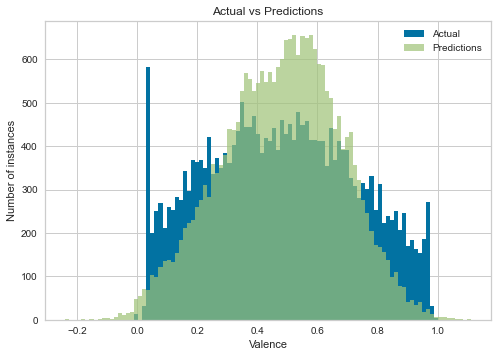

(0.11069267685799622, 0.019725716314327804, 0.0010972106324615345)

In [15]:
cat_model  = CatBoostRegressor(verbose=0, random_seed=42, iterations=None,
        learning_rate=None,
        depth=None,
        l2_leaf_reg=None)


cat_model.fit(X_train, y_train)
pred_best_cat_model = cat_model.predict(X_test)
compare_predictions(y_test, pred_best_cat_model)
mean_absolute_error(pred_best_cat_model, y_test) , mean_squared_error(pred_best_cat_model, y_test),  (pred_best_cat_model-y_test).mean()

In [ ]:
plot_model_var_imp(xgb_best, X_train)

## NN Model

* while the NN model did not perform as expected, A model has been created under the helper functions whose performance may be validated by running the following cell:

In [ ]:
nn_model = run_NN(X_train, X_test, y_train, y_test)

## Perform Predictions on Test Dataset

* Having loaded the test song ids and created the corresponding csv file, we can load the file and perform predictions based on the best models. 

In [12]:
del X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = df_ml.iloc[:,:-1], test_df.iloc[:,:-1], df_ml.iloc[:,-1], test_df.iloc[:,-1]

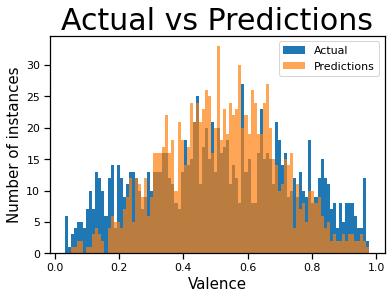

(0.0874999664082689, 0.015826527700827733, 0.00693131007751937)

In [13]:
# Get predictions
# Best model
et = ExtraTreesRegressor(random_state=123)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)
compare_predictions(y_test, pred_et)
mean_absolute_error(pred_et, y_test) , mean_squared_error(pred_et, y_test),  (pred_et-y_test).mean() 

<a id='pycaret'></a>
# Appendix 1: Initial model selection using Pycaret

In order to determine which models are going to be used we are going to compare a number of models using the library pycaret, which makes it easy to compare various models.

In [ ]:
!pip install  --ignore-installed --use-deprecated=legacy-resolver pycaret[full]

In [ ]:

exp_reg101 = setup(data = df_ml, target = 'valence', session_id=123, train_size=0.8,  
                  #  remove_outliers=True, create_clusters=True, cluster_iter=30, 
                   silent=True) 

,Description,Value
0,session_id,123
1,Target,valence
2,Original Data,"(100401, 46)"
3,Missing Values,False
4,Numeric Features,42
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(80320, 59)"


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1106,0.0197,0.1404,0.6771,0.0959,0.3931,32.172
xgboost,Extreme Gradient Boosting,0.1154,0.0216,0.1471,0.6457,0.1005,0.4116,69.554
et,Extra Trees Regressor,0.1143,0.0229,0.1512,0.6257,0.1033,0.4417,106.323
lightgbm,Light Gradient Boosting Machine,0.1199,0.0229,0.1512,0.6255,0.1033,0.4357,2.858
rf,Random Forest Regressor,0.1197,0.0236,0.1536,0.6137,0.1049,0.4556,285.222
gbr,Gradient Boosting Regressor,0.1326,0.0272,0.1648,0.5552,0.1125,0.5049,88.395
lr,Linear Regression,0.1370,0.0293,0.1712,0.5200,0.1168,0.5580,0.483
ridge,Ridge Regression,0.1370,0.0293,0.1712,0.5200,0.1168,0.5580,0.063
br,Bayesian Ridge,0.1370,0.0293,0.1712,0.5200,0.1168,0.5580,0.531
lar,Least Angle Regression,0.1372,0.0295,0.1718,0.5165,0.1172,0.5586,0.079


<a id='Appendix_2'></a>
# Appendix 2: Download extra songs using Scraping and Spotify API

## Scrap Spotify profile

* For this next section we are going to use selenium and Beautiful Soup to download playlists, which are then going to be used to extract the songs from them. 
We Searched online for Spotify spofiles that upload trending playlists and using the mentioned libraries, we found and downloaded all links from the "playlist" part of their profile. The users used in this section are:
* [spotify](https://open.spotify.com/user/spotify/playlists)
* [patreeeek](https://open.spotify.com/user/patreeeek/playlists)
* [gotafli](https://open.spotify.com/user/gotafli/playlists)
* [holgerchristoph](https://open.spotify.com/user/holgerchristoph/playlists )
* [baskrud](https://open.spotify.com/user/baskrud/playlists)
* [jagheterjohanheterjag](https://open.spotify.com/user/jagheterjohanheterjag/playlists)

Moreover to make this section independent of the explorer installed, we will use the webdriver-manager library to create a virtual chrome driver.
You May install the library using:

In [ ]:
!pip install webdriver-manager

In [119]:
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
import re
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager

# options = Options()
# options.headless = True

# Download all the playlists for the users in question
spotify_playlists = []
for link in ['https://open.spotify.com/user/spotify/playlists', 'https://open.spotify.com/user/patreeeek/playlists', 
            'https://open.spotify.com/user/gotafli/playlists', 'https://open.spotify.com/user/holgerchristoph/playlists', 
            'https://open.spotify.com/user/baskrud/playlists', 'https://open.spotify.com/user/jagheterjohanheterjag/playlists']:
    with webdriver.Chrome(ChromeDriverManager().install()) as driver:
        # driver.implicitly_wait(30)
        driver.get(link)
        soup = BeautifulSoup(driver.page_source, 'html.parser')

    review_titles_list = soup.find_all("a")
    for review_title in review_titles_list:
        try:
            if 'playlist/' in review_title['href']:
                string = str(review_title['href'].split('/')[-1])
                spotify_playlists.append(string)
        except:
            continue
    



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/97.0.4692.71/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\jojoshulk\.wdm\drivers\chromedriver\win32\97.0.4692.71]


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\jojoshulk\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\jojoshulk\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\jojoshulk\.wd

In [145]:
def get_songs_from_playlist(input_playlist):   
    # get the tracks found in the playsis id 
    track_ids_pl = []
    # Iterate through downloaded playlists
    print('Getting songs...', end='')
    for playlist in input_playlist:
        print('.', end='')
        # get the tracks' info through the API
        track_items = sp.playlist(playlist)['tracks']['items']

        for item in track_items:
            try:
                # if the song is unique across all lists skip else append to list
                if item['track']['id'] not in list(features.keys()) + track_ids_pl + list(features_test.keys()):
                    track_ids_pl.append(item['track']['id'])
            except:
                continue

    # Remove items that are of None type
    topop = []
    for i, it in enumerate(track_ids_pl):
        if it is None:
            topop.append(i)
    for i in topop:
        del track_ids_pl[i]

    # get the features for the tracks
    features_pl = get_features(track_ids_pl)       

    # pop songs with issues
    to_pop = []
    for i, val in features_pl.items():
        if type(val) != dict:
            to_pop.append(i)
    # remove files that are present in the test dataset
        if i in features_test.keys():
            to_pop.append(i)        

    _ = [features_pl.pop(i) for i in to_pop]

    return features_pl


features_extra = get_songs_from_playlist(spotify_playlists)
print("Unique songs: ", len(features_extra))

Getting songs...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 20

* This part downloads the exrta features under the `segment` and `section` part of the audio analysis, and will take a lot of time to be excecuted.

In [36]:
update_with_extra_features(features_extra)

to_pop = []
for i, val in features_extra.items():
    # remove files that don't have audio analysis
    if 'pitch_0' not in val.keys():
        to_pop.append(i)

_ = [features_extra.pop(i) for i in to_pop]

Start fetching extra features
fetching 0 of 34515
fetching 100 of 34515
fetching 200 of 34515
fetching 300 of 34515
fetching 400 of 34515
fetching 500 of 34515
fetching 600 of 34515
fetching 700 of 34515
fetching 800 of 34515
fetching 900 of 34515
fetching 1000 of 34515
fetching 1100 of 34515
fetching 1200 of 34515
fetching 1300 of 34515
fetching 1400 of 34515
fetching 1500 of 34515
fetching 1600 of 34515
fetching 1700 of 34515
fetching 1800 of 34515
fetching 1900 of 34515
fetching 2000 of 34515
fetching 2100 of 34515
fetching 2200 of 34515
fetching 2300 of 34515
fetching 2400 of 34515
fetching 2500 of 34515
fetching 2600 of 34515
fetching 2700 of 34515
fetching 2800 of 34515
Waiting for 1 sec
Waiting for 1 sec
fetching 2900 of 34515
fetching 3000 of 34515
fetching 3100 of 34515
fetching 3200 of 34515
fetching 3300 of 34515
fetching 3400 of 34515
fetching 3500 of 34515
fetching 3600 of 34515
fetching 3700 of 34515
fetching 3800 of 34515
fetching 3900 of 34515
fetching 4000 of 34515
fet

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/141S5b39xDpltWjOIf5AK0 with Params: {} returned 404 due to analysis not found


Waiting for 1 sec
fetching 22900 of 34515
fetching 23000 of 34515
fetching 23100 of 34515
fetching 23200 of 34515
fetching 23300 of 34515
fetching 23400 of 34515
fetching 23500 of 34515
fetching 23600 of 34515
fetching 23700 of 34515
fetching 23800 of 34515
fetching 23900 of 34515
fetching 24000 of 34515
fetching 24100 of 34515
fetching 24200 of 34515
fetching 24300 of 34515
fetching 24400 of 34515
fetching 24500 of 34515
fetching 24600 of 34515
fetching 24700 of 34515
fetching 24800 of 34515
fetching 24900 of 34515
fetching 25000 of 34515
fetching 25100 of 34515
fetching 25200 of 34515
fetching 25300 of 34515
fetching 25400 of 34515
fetching 25500 of 34515
fetching 25600 of 34515
fetching 25700 of 34515
fetching 25800 of 34515
fetching 25900 of 34515
fetching 26000 of 34515
fetching 26100 of 34515
fetching 26200 of 34515
fetching 26300 of 34515
fetching 26400 of 34515
fetching 26500 of 34515
fetching 26600 of 34515
fetching 26700 of 34515
fetching 26800 of 34515
fetching 26900 of 3451

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/55VCuegnNc7Bdno12IPayP with Params: {} returned 404 due to analysis not found


Waiting for 1 sec
fetching 31800 of 34515
fetching 31900 of 34515
fetching 32000 of 34515
fetching 32100 of 34515
fetching 32200 of 34515
fetching 32300 of 34515
fetching 32400 of 34515
fetching 32500 of 34515
fetching 32600 of 34515
fetching 32700 of 34515
fetching 32800 of 34515
fetching 32900 of 34515
fetching 33000 of 34515
fetching 33100 of 34515
fetching 33200 of 34515
fetching 33300 of 34515
fetching 33400 of 34515
fetching 33500 of 34515
fetching 33600 of 34515
fetching 33700 of 34515
fetching 33800 of 34515
fetching 33900 of 34515
fetching 34000 of 34515
fetching 34100 of 34515
fetching 34200 of 34515
fetching 34300 of 34515
fetching 34400 of 34515
fetching 34500 of 34515


In [37]:
df_new = pd.DataFrame.from_dict(features_extra, orient='index').reset_index().rename(columns={'index': 'song_id'})
df_new.to_csv('./audio_features_spotify_scrap.csv', index=False)


if os.path.exists('./audio_features_spotify_scrap.csv'):
    print('File already exists, not saving.')
    pass
else:
    df_new.to_csv('./audio_features_spotify_scrap.csv', index=False)
    print('Dataframe saved under audio_features_spotify_scrap.csv')

df_new.head()
del df_new, features_extra, spotify_playlists

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11
0,1nH2PkJL1XoUq8oE6tBZoU,0.695,0.7900,7,-6.469,1,0.0976,0.0317,0.000072,0.0683,...,-7.685913,2.940100,18.017920,-25.944946,-1.868988,0.200709,-0.111619,-0.194429,-10.604118,-1.654497
1,3USxtqRwSYz57Ewm6wWRMp,0.761,0.5250,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,...,-48.685406,-8.622153,29.777887,-17.997246,-4.376639,-13.849308,-11.603144,-1.068441,-18.017587,1.061119
2,5XbA7TAqsD0fj0dGBrbb0D,0.748,0.8410,2,-5.460,1,0.1900,0.1000,0.000000,0.3080,...,-6.185232,-0.725247,22.851355,-17.089653,-4.078087,-6.441568,-4.050737,4.592924,-15.080369,-3.896000
3,6bQfNiqyCX7UaQSvVVGo4I,0.788,0.8590,2,-2.724,1,0.0856,0.2810,0.000000,0.0424,...,-2.110731,5.499444,43.277661,-12.714876,-13.427393,-2.253812,-10.370963,6.606463,-16.988224,-2.798875
4,5dPz35akJjPqb17yeqNwqH,0.604,0.7410,2,-5.571,1,0.0475,0.1780,0.000035,0.4090,...,5.243460,3.971516,20.292757,-31.701919,7.116644,-2.467453,-8.101817,0.355560,-10.764924,-3.085484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34505,11dTnaie5BRo7EFXuVARSy,0.811,0.4200,6,-14.690,0,0.0745,0.6380,0.802000,0.1050,...,-77.807094,-9.667942,15.145659,-43.051683,-10.356990,-3.975438,7.986661,5.033702,-10.811934,1.440127
34506,0Ztok1tyr8YbgTi6iUJM9X,0.770,0.7080,6,-10.561,1,0.1140,0.2910,0.098700,0.0786,...,-47.645614,-0.160929,41.437558,-28.750439,-10.861357,-10.186838,-0.357227,-4.776352,-8.245600,2.647320
34507,7pH3QwT1y8SCzNq9tkTCBa,0.627,0.4080,5,-7.298,1,0.0430,0.5130,0.000325,0.0993,...,-10.507869,-17.260588,7.500305,-15.834003,-7.017724,-3.254725,-1.239489,-3.226173,-13.266048,-0.725927
34508,4vWY7fEgnUqsohnF5nwtMM,0.558,0.8160,5,-8.321,0,0.0405,0.0330,0.007570,0.2710,...,4.313873,4.055172,34.127475,-43.812307,3.060466,-9.528965,-7.431595,10.237712,-10.189900,0.183778


## Use the search API

Spotify also offers the ['Search for Item API`](https://developer.spotify.com/documentation/web-api/reference/#/operations/search). This is a great way of obtaining a lot of songs.

* we can search the etnire platform for the term "Spotify" this yields a lot of results (appr. 53k songs). We will follow the same procedure for these songs to get the features. 

In [138]:
# download all playlists with the term "spotify"
lists = []
for offset in range(0, 1000,50):
    for i in sp.search('spotify', type='playlist', limit=50, offset=offset)['playlists']['items']:
        if i['id'] not in lists:
            lists.append(i['id'])
len(lists)


974

* Having 974 playlists, we can fetch all songs from them and also get the features. Keep in mind that this takes an extended amount of time.

In [146]:
features_extra = get_songs_from_playlist(lists)
print("Unique songs: ", len(features_extra))

Getting songs.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................getting fr

* This part downloads the exrta features under the `segment` and `section` part of the audio analysis, and will take a lot of time to be excecuted.

In [134]:
update_with_extra_features(features_extra)


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/2s2SBclo5qzdMxKV9GLRme with Params: {} returned 404 due to analysis not found


Start fetching extra features
fetching 0 of 52793
fetching 100 of 52793
fetching 200 of 52793
fetching 300 of 52793
fetching 400 of 52793
fetching 500 of 52793
fetching 600 of 52793
fetching 700 of 52793
fetching 800 of 52793
fetching 900 of 52793
fetching 1000 of 52793
fetching 1100 of 52793
fetching 1200 of 52793
fetching 1300 of 52793
fetching 1400 of 52793
fetching 1500 of 52793
fetching 1600 of 52793
fetching 1700 of 52793
fetching 1800 of 52793
fetching 1900 of 52793
fetching 2000 of 52793
fetching 2100 of 52793
fetching 2200 of 52793
Waiting for 1 sec


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4zljt7RRFkNAy3R3tX1gRe with Params: {} returned 404 due to analysis not found


fetching 2300 of 52793
fetching 2400 of 52793
fetching 2500 of 52793
fetching 2600 of 52793
fetching 2700 of 52793
fetching 2800 of 52793
Waiting for 1 sec
fetching 2900 of 52793
fetching 3000 of 52793
fetching 3100 of 52793
fetching 3200 of 52793
fetching 3300 of 52793
fetching 3400 of 52793
fetching 3500 of 52793
fetching 3600 of 52793
fetching 3700 of 52793
fetching 3800 of 52793
fetching 3900 of 52793
fetching 4000 of 52793
fetching 4100 of 52793
fetching 4200 of 52793
fetching 4300 of 52793
fetching 4400 of 52793
fetching 4500 of 52793
fetching 4600 of 52793
fetching 4700 of 52793
fetching 4800 of 52793
fetching 4900 of 52793
fetching 5000 of 52793
fetching 5100 of 52793
fetching 5200 of 52793
fetching 5300 of 52793
fetching 5400 of 52793
fetching 5500 of 52793
fetching 5600 of 52793
fetching 5700 of 52793
fetching 5800 of 52793
fetching 5900 of 52793
fetching 6000 of 52793
fetching 6100 of 52793
fetching 6200 of 52793
fetching 6300 of 52793
fetching 6400 of 52793
fetching 6500 of

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5TS51iQud7BUVEwoKqMvVz with Params: {} returned 404 due to analysis not found


fetching 21700 of 52793
fetching 21800 of 52793
fetching 21900 of 52793
fetching 22000 of 52793
fetching 22100 of 52793
fetching 22200 of 52793
fetching 22300 of 52793
fetching 22400 of 52793
fetching 22500 of 52793
fetching 22600 of 52793
fetching 22700 of 52793
fetching 22800 of 52793
fetching 22900 of 52793
fetching 23000 of 52793
fetching 23100 of 52793
fetching 23200 of 52793
fetching 23300 of 52793
fetching 23400 of 52793
fetching 23500 of 52793
fetching 23600 of 52793
fetching 23700 of 52793
fetching 23800 of 52793
fetching 23900 of 52793
fetching 24000 of 52793
fetching 24100 of 52793
fetching 24200 of 52793
fetching 24300 of 52793
fetching 24400 of 52793
fetching 24500 of 52793
fetching 24600 of 52793
fetching 24700 of 52793
Waiting for 1 sec


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5cY8y2XgOfkAh4kSWLFKkz with Params: {} returned 404 due to analysis not found


fetching 24800 of 52793
fetching 24900 of 52793
fetching 25000 of 52793
fetching 25100 of 52793
fetching 25200 of 52793
fetching 25300 of 52793
fetching 25400 of 52793
fetching 25500 of 52793
fetching 25600 of 52793
fetching 25700 of 52793
fetching 25800 of 52793
fetching 25900 of 52793
fetching 26000 of 52793
fetching 26100 of 52793
fetching 26200 of 52793
fetching 26300 of 52793
fetching 26400 of 52793
fetching 26500 of 52793
fetching 26600 of 52793
fetching 26700 of 52793
fetching 26800 of 52793
fetching 26900 of 52793
fetching 27000 of 52793
fetching 27100 of 52793
fetching 27200 of 52793
fetching 27300 of 52793
fetching 27400 of 52793
fetching 27500 of 52793
fetching 27600 of 52793
fetching 27700 of 52793
fetching 27800 of 52793
fetching 27900 of 52793
fetching 28000 of 52793
fetching 28100 of 52793
fetching 28200 of 52793
fetching 28300 of 52793
fetching 28400 of 52793
fetching 28500 of 52793
fetching 28600 of 52793
fetching 28700 of 52793
Waiting for 1 sec
fetching 28800 of 5279

Max Retries reached


Waiting for 1 sec
fetching 29100 of 52793


Max Retries reached


Waiting for 1 sec


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/2IggMTlkERCVSYu2OIiG49 with Params: {} returned 404 due to analysis not found


fetching 29200 of 52793
fetching 29300 of 52793
fetching 29400 of 52793
fetching 29500 of 52793
fetching 29600 of 52793
fetching 29700 of 52793
fetching 29800 of 52793
fetching 29900 of 52793
fetching 30000 of 52793
fetching 30100 of 52793
fetching 30200 of 52793
fetching 30300 of 52793
fetching 30400 of 52793
fetching 30500 of 52793
fetching 30600 of 52793
fetching 30700 of 52793
fetching 30800 of 52793
fetching 30900 of 52793
fetching 31000 of 52793
fetching 31100 of 52793
fetching 31200 of 52793
Waiting for 1 sec
fetching 31300 of 52793
fetching 31400 of 52793
fetching 31500 of 52793
fetching 31600 of 52793
fetching 31700 of 52793
fetching 31800 of 52793
fetching 31900 of 52793
fetching 32000 of 52793
fetching 32100 of 52793
fetching 32200 of 52793
fetching 32300 of 52793
fetching 32400 of 52793
fetching 32500 of 52793
fetching 32600 of 52793
fetching 32700 of 52793
fetching 32800 of 52793
fetching 32900 of 52793
fetching 33000 of 52793
fetching 33100 of 52793
fetching 33200 of 5279

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5EnQ2C6iR3qRVsdbFKAoGE with Params: {} returned 404 due to analysis not found


fetching 35700 of 52793
fetching 35800 of 52793
fetching 35900 of 52793
fetching 36000 of 52793
fetching 36100 of 52793
fetching 36200 of 52793
fetching 36300 of 52793
fetching 36400 of 52793
fetching 36500 of 52793
fetching 36600 of 52793
fetching 36700 of 52793
fetching 36800 of 52793
fetching 36900 of 52793
fetching 37000 of 52793
fetching 37100 of 52793
fetching 37200 of 52793
fetching 37300 of 52793
fetching 37400 of 52793
fetching 37500 of 52793
fetching 37600 of 52793
fetching 37700 of 52793
fetching 37800 of 52793
fetching 37900 of 52793
fetching 38000 of 52793
fetching 38100 of 52793
Waiting for 1 sec


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/0S5VuNjfD3nLv4yhgEgSPI with Params: {} returned 404 due to analysis not found


fetching 38200 of 52793
fetching 38300 of 52793
fetching 38400 of 52793
fetching 38500 of 52793
fetching 38600 of 52793
fetching 38700 of 52793
fetching 38800 of 52793
fetching 38900 of 52793
fetching 39000 of 52793
fetching 39100 of 52793
fetching 39200 of 52793
fetching 39300 of 52793
fetching 39400 of 52793
fetching 39500 of 52793
fetching 39600 of 52793
fetching 39700 of 52793
fetching 39800 of 52793
fetching 39900 of 52793
fetching 40000 of 52793
fetching 40100 of 52793
fetching 40200 of 52793
fetching 40300 of 52793
fetching 40400 of 52793
fetching 40500 of 52793
fetching 40600 of 52793
fetching 40700 of 52793
fetching 40800 of 52793
fetching 40900 of 52793
fetching 41000 of 52793
fetching 41100 of 52793
fetching 41200 of 52793
fetching 41300 of 52793
fetching 41400 of 52793
fetching 41500 of 52793
fetching 41600 of 52793
fetching 41700 of 52793
fetching 41800 of 52793
fetching 41900 of 52793
fetching 42000 of 52793
fetching 42100 of 52793
fetching 42200 of 52793
fetching 42300 o

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ with Params: {} returned 404 due to analysis not found


fetching 43000 of 52793
fetching 43100 of 52793
fetching 43200 of 52793
fetching 43300 of 52793
fetching 43400 of 52793
fetching 43500 of 52793
fetching 43600 of 52793
fetching 43700 of 52793
fetching 43800 of 52793
fetching 43900 of 52793
fetching 44000 of 52793
fetching 44100 of 52793
fetching 44200 of 52793
fetching 44300 of 52793
fetching 44400 of 52793
fetching 44500 of 52793
fetching 44600 of 52793
fetching 44700 of 52793
fetching 44800 of 52793
fetching 44900 of 52793
fetching 45000 of 52793
fetching 45100 of 52793
fetching 45200 of 52793
fetching 45300 of 52793
fetching 45400 of 52793
fetching 45500 of 52793
fetching 45600 of 52793
fetching 45700 of 52793
fetching 45800 of 52793
fetching 45900 of 52793
fetching 46000 of 52793
fetching 46100 of 52793
fetching 46200 of 52793
fetching 46300 of 52793
fetching 46400 of 52793
fetching 46500 of 52793
fetching 46600 of 52793
fetching 46700 of 52793
fetching 46800 of 52793
fetching 46900 of 52793
fetching 47000 of 52793
fetching 47100 o

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/72ozIjVFHpAnKGcuYpCfb7 with Params: {} returned 404 due to analysis not found


fetching 49300 of 52793
Waiting for 1 sec
fetching 49400 of 52793
fetching 49500 of 52793


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5v6GG5IseIoLQdEvDJka9S with Params: {} returned 404 due to analysis not found


fetching 49600 of 52793
fetching 49700 of 52793
fetching 49800 of 52793
fetching 49900 of 52793
fetching 50000 of 52793
fetching 50100 of 52793
fetching 50200 of 52793
fetching 50300 of 52793
fetching 50400 of 52793
fetching 50500 of 52793
fetching 50600 of 52793
fetching 50700 of 52793
fetching 50800 of 52793
fetching 50900 of 52793
fetching 51000 of 52793
Waiting for 1 sec


HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/2EPPAtZHjTnVYXXAOfg4av with Params: {} returned 404 due to analysis not found


fetching 51100 of 52793
fetching 51200 of 52793
fetching 51300 of 52793
fetching 51400 of 52793
fetching 51500 of 52793
fetching 51600 of 52793
fetching 51700 of 52793
fetching 51800 of 52793
fetching 51900 of 52793
fetching 52000 of 52793
Waiting for 1 sec
fetching 52100 of 52793
fetching 52200 of 52793
fetching 52300 of 52793
fetching 52400 of 52793
fetching 52500 of 52793
fetching 52600 of 52793
fetching 52700 of 52793


In [157]:
to_pop = []
for i, val in features_extra.items():
    # remove files that don't have audio analysis
    if 'pitch_0' not in val.keys():
        to_pop.append(i)
    
    # remove files that are present in the test dataset
    if i in features_test.keys():
        to_pop.append(i)

_ = [features_extra.pop(i) for i in to_pop]

df_new = pd.DataFrame.from_dict(features_extra, orient='index').reset_index().rename(columns={'index': 'song_id'})

# save the df
if os.path.exists('./audio_features_spotify_search.csv'):
    print('File already exists, not saving.')
    pass
else:
    df_new.to_csv('./audio_features_spotify_search.csv', index=False)
    print('Dataframe saved under audio_features_spotify_search.csv')

df_new.head()
del df_new, features_extra, lists

Dataframe saved under audio_features_spotify_search.csv
